# mlarena Advanced Usage

This notebook demonstrates more advanced usage of the `mlarena` library for ML model optimization.

1. PreProcessing strategy analysis
2. Custom configure algorithms and preprocessing strategy
3. Bayesian Hyperparameter tuning
4. Threshold analysis for classification models

In [2]:
# Standard library imports
import multiprocessing
import os

# Third-party imports
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Local imports
from mlarena import MLPipeline, PreProcessor
import mlflow
mlflow.autolog(disable=True)

# Configure parallel processing
# Only needed when running locally (not required on distributed platforms like Databricks)
n_cores = multiprocessing.cpu_count()
n_jobs = max(1, n_cores // 2)  # Use half of available cores to avoid overloading
os.environ["LOKY_MAX_CPU_COUNT"] = str(n_jobs)


# 1. PreProcessing Strategy Analysis

In [3]:
# Create demo dataset
np.random.seed(42)
n_samples = 1000
data = pd.DataFrame({
    # Numeric features
    'age': np.random.normal(35, 10, n_samples),
    'income': np.random.lognormal(100, 10, n_samples),
    'tenure': np.random.poisson(5, n_samples),
    
    # Categorical features with low cardinality
    'education': np.random.choice(['High School', 'Bachelor', 'Master or above'], n_samples),
    'occupation': np.random.choice(['Engineer'], n_samples), #only one value
    
    # Categorical features with higher cardinality
    'city': np.random.choice(
        ['NYC']*500 + ['LA']*300 + ['Chicago']*150 + ['Miami']*30 + ['Seattle']*20,
        n_samples
    ),
    'product': np.random.choice(
        ['A']*600 + ['B']*250 + ['C']*80 + ['D']*30 + ['E']*20 + ['F']*20,
        n_samples
    )
})

# Add some missing values
data.loc[np.random.choice(n_samples, 50), 'age'] = np.nan
data.loc[np.random.choice(n_samples, 30), 'education'] = np.nan
data.loc[np.random.choice(n_samples, 20), 'city'] = np.nan

# Create target variable that depends on features
target = pd.Series(np.random.binomial(1, 0.5, n_samples))
target.loc[data['city'] == 'NYC'] = np.random.binomial(1, 0.8, sum(data['city'] == 'NYC'))
target.loc[data['city'] == 'Seattle'] = np.random.binomial(1, 0.2, sum(data['city'] == 'Seattle'))
target.loc[data['product'] == 'A'] = np.random.binomial(1, 0.7, sum(data['product'] == 'A'))
target.loc[data['product'] == 'E'] = np.random.binomial(1, 0.1, sum(data['product'] == 'E'))

# Split data              
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

## 1.1 Filter Feature Selection

Run filter feature selection based on:
* Missing value threshold - features with missing rate above threshold will be excluded
* Single value features - features with only one unique value will be excluded  
* Mutual information threshold - features with mutual information score below threshold will be excluded (ignored if top_n is set)
* Top N features - optionally select top N features by mutual information score instead of using threshold

### 1.1.1 Selection by minimum mutual information

In [4]:
fitler_fs = PreProcessor.filter_feature_selection(X_train, y_train,
                                                  task = "classification",
                                                  missing_threshold = 0.2,
                                                  mi_threshold = 0.05)

Filter Feature Selection Summary:
Total features analyzed: 7

1. High missing ratio (>20.0%): 0 columns

2. Single value: 1 columns
   Columns: occupation

3. Low mutual information (<0.05): 3 columns
   Columns: age, tenure, occupation

Recommended drops: (3 columns in total)


In [5]:
# detailed results available as a dataframe
fitler_fs['analysis']

,feature,missing_ratio,n_unique,n_unique_ratio,dtype,mutual_info,mutual_info_normalized,drop_missing,drop_unique,drop_mi
0,city,0.0200,5,0.00625,object,0.016899,1.000000,False,False,False
1,product,0.0000,6,0.00750,object,0.011228,0.664413,False,False,False
2,income,0.0000,800,1.00000,float64,0.001354,0.080128,False,False,False
3,education,0.0275,3,0.00375,object,0.000904,0.053503,False,False,False
4,age,0.0475,762,0.95250,float64,0.000000,0.000000,False,False,True
5,tenure,0.0000,13,0.01625,int32,0.000000,0.000000,False,False,True
6,occupation,0.0000,1,0.00125,object,0.000000,0.000000,False,True,True


In [6]:
selected_cols = fitler_fs['selected_cols']
print("Selected columbns include:", ", ".join(selected_cols))

Selected columbns include: city, product, income, education


### 1.1.2 Selection by `n_top_features`

In [7]:
fitler_fs_top_n = PreProcessor.filter_feature_selection(X_train, y_train,
                                                  task = "classification",
                                                  missing_threshold = 0.2,
                                                  n_top_features= 3)

Filter Feature Selection Summary:
Total features analyzed: 7

1. High missing ratio (>20.0%): 0 columns

2. Single value: 1 columns
   Columns: occupation

3. Not in top 3 features: 3 columns
   Columns: education, age, tenure

Recommended drops: (4 columns in total)


In [8]:
selected_cols = fitler_fs_top_n['selected_cols']
print("Selected columbns include:", ", ".join(selected_cols))

Selected columbns include: city, product, income


## 1.2 Recommend encoding candidates

The `identify_encoding_candidates` method recommend encoding based on:

1. High cardinality threshold
2. Rare category
3. User preference

**Note**: The function is intended for rapid reference only. For robust preprocessing decisions—including encoding choices, it is always best practice to perform thorough Exploratory Data Analysis (EDA) to understand your data. For example, examining distributions, category frequencies, missing patterns, and other relevant characteristics can help inform preprocessing strategies.

In [9]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train[selected_cols], 
                                                                 high_cardinality_threshold=5)

-------------------------
Column `city` Analysis:
Recommend target encoding with higher smoothing due to moderate cardinality and rare category

column `city` details:
• Missing rate: 2.0%
• Unique values: 5
• Minimum category size: 24
• Rare categories: 2
-------------------------
Column `product` Analysis:
Recommend target encoding with higher smoothing parameter due to high cardinality and rare categories

column `product` details:
• Missing rate: 0.0%
• Unique values: 6
• Minimum category size: 14
• Rare categories: 3
-------------------------

Summary:
• Target encoding cols: 2
• One-hot encoding cols: 0


In [10]:
# access the detailed analysis in dataframe form if preferred
encoding_recommendations['analysis']

,column,missing_rate,unique_values,min_category_size,rare_categories,encoding_note
0,city,0.02,5,24,2,"Has 2 rare categories, careful for sparse feat..."
1,product,0.00,6,14,3,Has 3 rare categories. Recommend higher smooth...


In [11]:
target_encode_cols = encoding_recommendations['target_encode_cols']
preprocessor = PreProcessor(
    target_encode_cols=target_encode_cols,
    target_encode_smooth='auto'
)
X_train_preprocessed = preprocessor.fit_transform(X_train[selected_cols],y_train)
X_test_preprocessed =  preprocessor.transform(X_test[selected_cols])

## 1.3 Compare Smoothing Strategies

Once the target encoding columns have been selected, the next decision we need to make is about the best smoothing strategies, which can be used to balance between the raw category means and the global mean to avoid overfitting. Two main smoothing strategies are available:

1. 'auto' - Automatically determines the smoothing parameter based on the dataset characteristics
2. Custom float value - Manually specify the smoothing strength (higher values = more smoothing)

As shown above, different smoothing strategies returns diffent result for a column of interests. The `plot_target_encoding_comparison` method visualizes how different smoothing parameters affect the encoded values. This is especially critical for categorical features with rare categories where overfitting is a bigger concern. Pls see below the visualization of `city`, where rare categories exist, and `education` with sufficiant sample sizes for each category. Smoothing parameters make a big difference for `city`, and in particular for the rare cagtegory Seattle whose train mean is much lower than the global mean. 

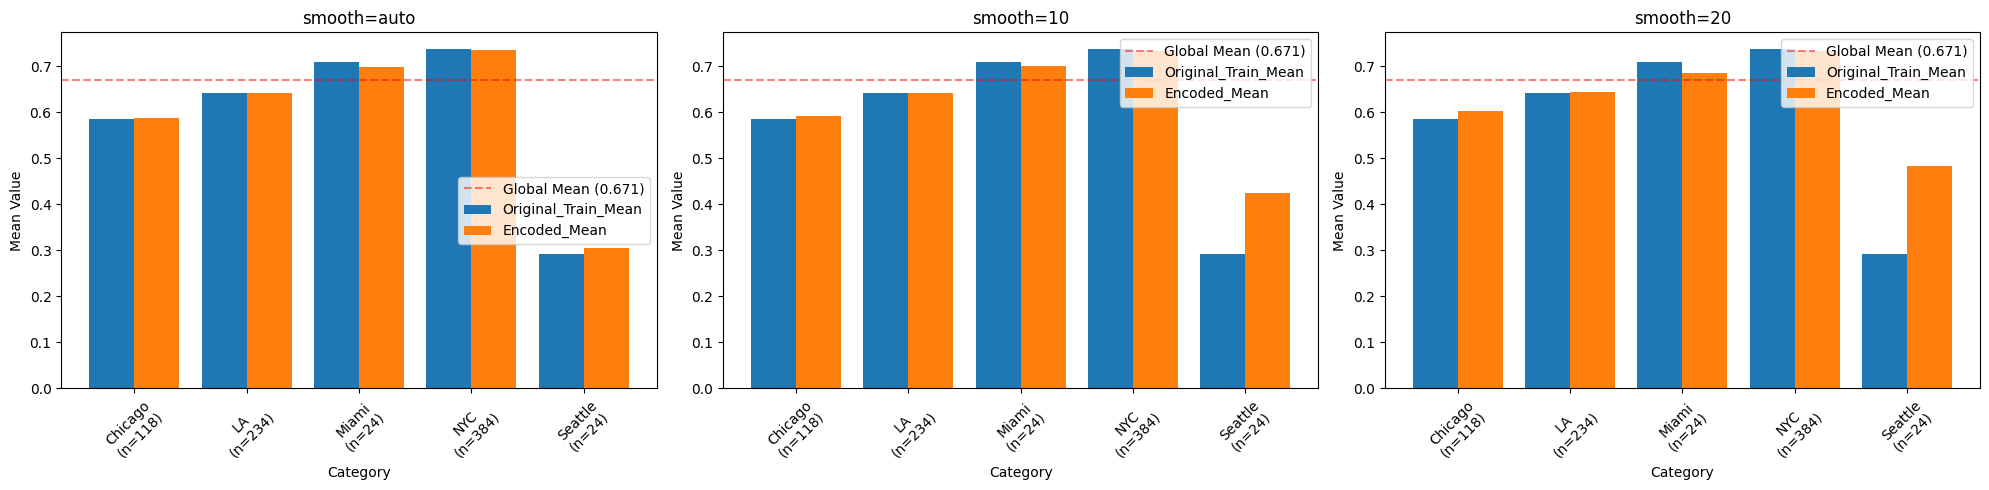

In [12]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'city',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

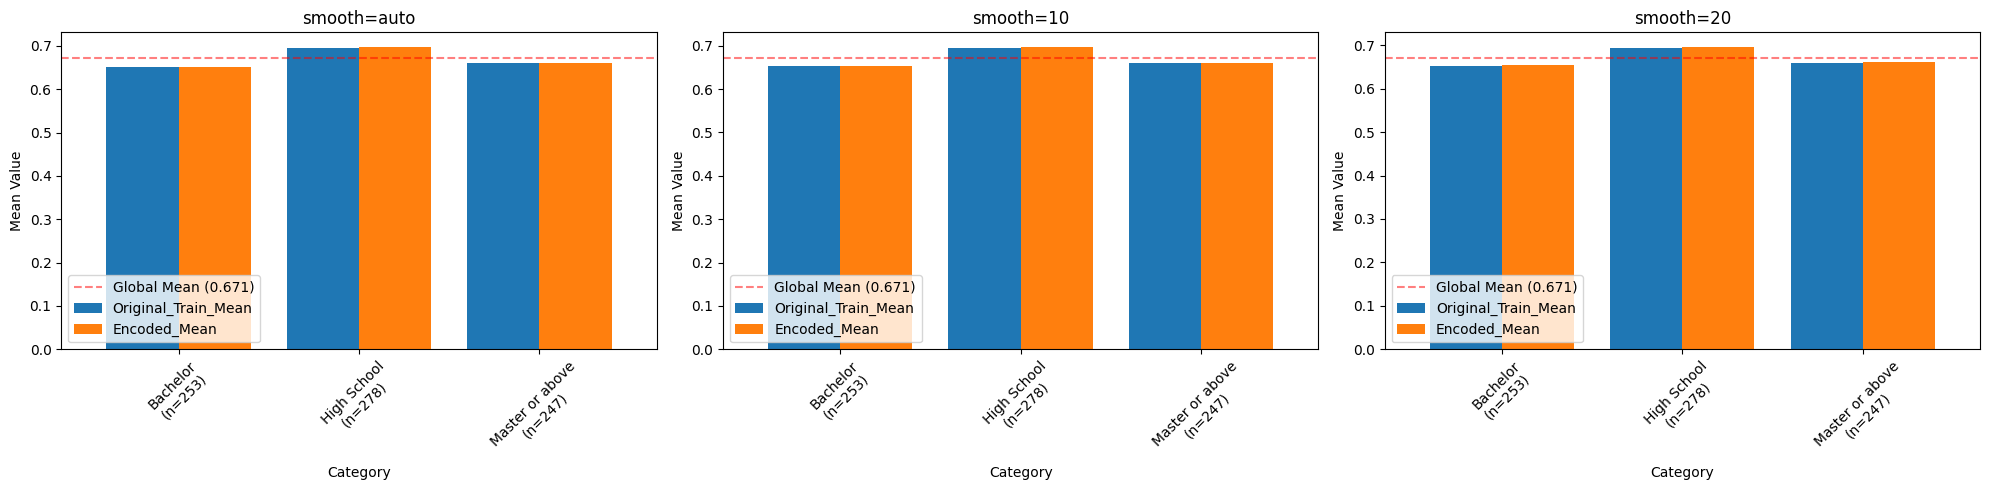

In [13]:
results = PreProcessor.plot_target_encoding_comparison(X_train, y_train, 
                                        target_encode_col= 'education',  
                                        smooth_params=['auto', 10, 20],
                                        figsize=(20, 5))

# 2. Custom Configure Algorithms and Preprocessing Strategy

In [14]:
# Load data
titanic = fetch_openml('titanic', version=1, as_frame=True)
X = titanic.data
y = titanic.target.astype(int)  
X = X.drop(['boat', 'body', 'home.dest', 'ticket', 'cabin', 'name'], axis=1)
X = PreProcessor.mlflow_input_prep(X)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)

In [15]:
encoding_recommendations = PreProcessor.encoding_recommendations(X_train)

-------------------------
Column `sex` Analysis:
Recommend one-hot encoding as the number of unique value is less or equal to 2

column `sex` details:
• Missing rate: 0.0%
• Unique values: 2
• Minimum category size: 278
• Rare categories: 0
-------------------------
Column `embarked` Analysis:
Either encoding will do due to moderate cardinality and sufficient sample size, feature added to target_encode_cols based on user preference

column `embarked` details:
• Missing rate: 0.1%
• Unique values: 3
• Minimum category size: 72
• Rare categories: 0
-------------------------

Summary:
• Target encoding cols: 1
• One-hot encoding cols: 1


In [16]:
# custom configure the algorithm and preprocessor
lgb_params = {
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "scale_pos_weight": 1.9,
    "verbose": -1
}
ml_pipeline = MLPipeline(
    model=lgb.LGBMClassifier(**lgb_params),
    preprocessor=PreProcessor(
        num_impute_strategy="mean",  # default "median"
        target_encode_cols=encoding_recommendations["target_encode_cols"],
    ),
)
ml_pipeline.fit(X_train, y_train)


=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.500    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.790    (Overall correct predictions)
• AUC:         0.833    (Ranking quality)
• Log Loss:    0.540    (Confidence-weighted error)
• Precision:   0.825    (True positives / Predicted positives)
• Recall:      0.678    (True positives / Actual positives)
• F1 Score:    0.744    (Harmonic mean of Precision & Recall)
• MCC:         0.577    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.370    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


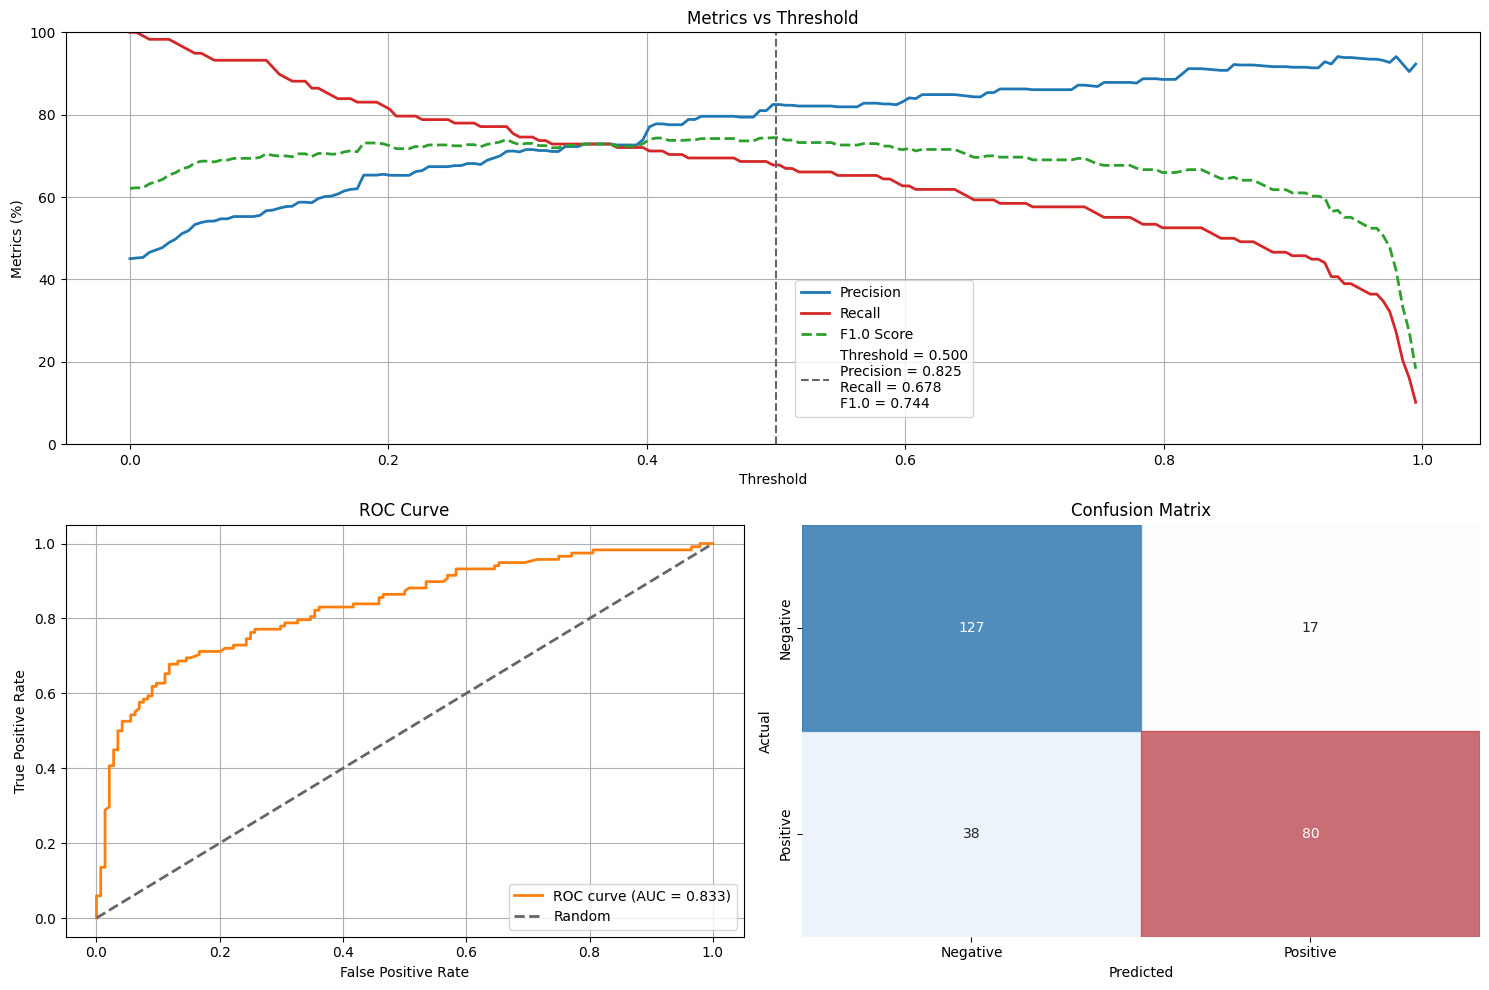

In [17]:
results = ml_pipeline.evaluate(X_test, y_test)

# 3. Model Explanations

Model explnanability can be super helpful in several ways:

- Model Selection: 
> It helps us select the best model by evaluating the soundness of its reasoning. Two algorithms may perform similarly on metrics like AUC or precision, but the key features they rely on may differ. Reviewing model reasoning with domain experts to discuss which model makes more sense in such scenarios is a good idea.
- Troubleshooting: 
> One helpful strategy for model improvement is to analyze the reasoning behind mistakes. For example, in classification problems, we can identify false positives where the model was most confident (i.e., produced the highest predicted possibilities) and investigate what went wrong in the reasoning and what key features contributed to the mistakes.
- Model Monitoring: 
> Besides the typical monitoring elements such as data drift and performance metrics, it is informative to monitor model reasoning as well. If there is a significant shift in key features that drive the decisions made by a model in production, I want to be alerted.
- Model Implementation: 
> In some scenarios, supplying model reasoning along with model predictions can be highly beneficial to our end users. For example, to help a customer service agent best retain a churning customer, we can provide the churn score alongside the customer features that contributed to this score.

MLPipeline has three built-in methods for model explanation. 
 - `explain_model`: Generates a global explanation of the model by computing SHAP values for all features on a given dataset. This helps you understand which features are most influential in the model's predictions overall, and visualizes their importance and impact direction.
 - `explain_case`: Produces a detailed, local explanation for a single prediction (specified by row index). It shows how each feature contributed to the final prediction for that specific case, making it easy to interpret individual decisions and investigate outliers or errors.
 - `explain_dependence`: Creates a SHAP dependence scatter plot for a selected feature (and optionally a second feature for interaction effects). This visualization reveals how the value of a feature affects the model's output, and can highlight non-linearities and interactions between features.

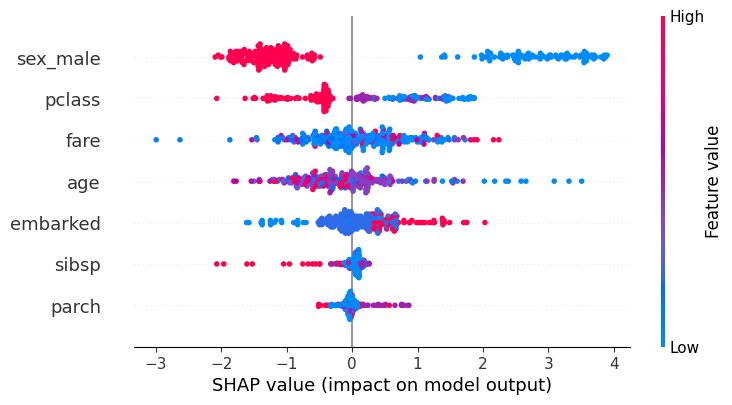

In [18]:
ml_pipeline.explain_model(X_test)

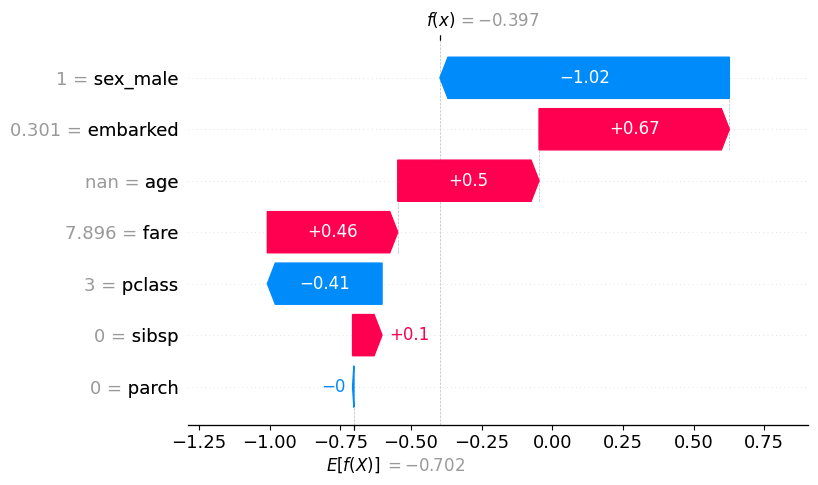

In [19]:
ml_pipeline.explain_case(3)

For the `explain_dependence` plot, when the user only specify `feature_1`, SHAP will automatically detect and display the feature with the strongest interaction effect (if any) by coloring the plot accordingly. Alternatively, the user can specify `feature_2` to explicitly examine the interaction between `feature_1` and a chosen second feature.

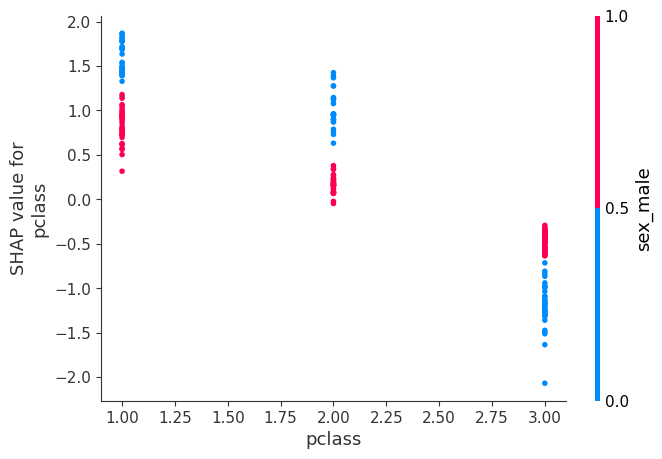

In [20]:
# sex_male is shown automatically as it has strong interaction effect with pclass
ml_pipeline.explain_dependence("pclass")

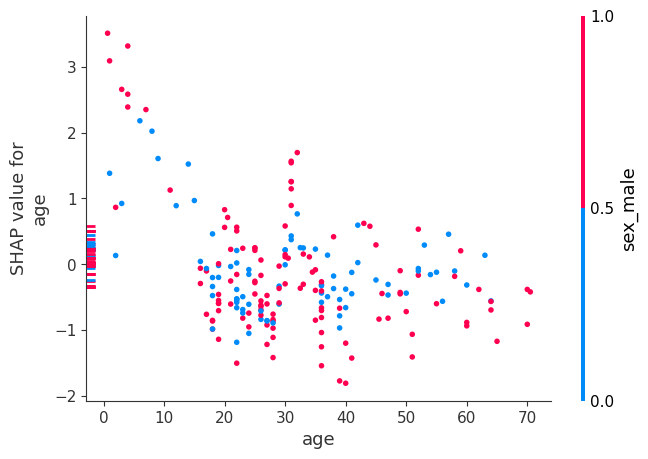

In [21]:
ml_pipeline.explain_dependence('age', 'sex_male')

# 4. Bayesian Hyperparameter Tuning

Below is a summary of three main approaches for hyperparameter tuning. 


| Approach        | Search Strategy                           | Efficiency  | Strengths                                           | Weaknesses                                       | When to Use |
|---------------|----------------------------------|------------|------------------------------------------------|------------------------------------------------|--------------|
| **Grid Search** | Exhaustive search over a predefined grid | Low         | - Guarantees finding the best combination (if small search space)  | - Computationally expensive, scales poorly with dimensionality | Small, well-defined search spaces |
| **Random Search** | Samples hyperparameters randomly | Medium      | - More efficient than grid search, explores more diverse values | - Does not leverage past results for better sampling | Large search spaces, unknown parameter importance |
| **Bayesian Optimization** | Builds a probabilistic model to guide search | High        | - Learns from past evaluations, focuses on promising areas | - More complex to implement, can be slower in early iterations | Optimize search routes for expensive evaluations to achieve the best result effectively |


<br>



The advantage of the Bayesian method over grid and random search is that it intelligently guides the search for optimal hyperparameters by leveraging past evaluations, making it more efficient and effective, especially in large or complex search spaces. While the approach is admittedly more complex, `mlarena` offers a `tune` method that makes it more approachable and easier to implement. Its features include 

- Iterative tuning using Tree-structured Parzen Estimators (TPE) via Optuna
- Implements k-fold cross-validation for robust evaluation
- Early stopping option to avoid overfitting and wasted computation
- Supports custom preprocessing pipelines
- Works well with any ML algorithm that follows sklearn API convensions
- Comprehensive reports with common metrics and plots
- Parallel coordinates plot for diagnosis of the search space


**Note about Plotly visualizations:** *The parellel coordinate plot for search space diagnostics is based on `plotly`. It displays correctly when running locally in Jupyter, VS Code, or other IDEs to support you in model optimization (see demo [on project ReadMe](https://github.com/MenaWANG/mlarena)). Unforerunately the demo may not render correctly when viewed on GitHub, which is a known limitation of GitHub's rendering engine. [Potential solutions were discussed here](https://stackoverflow.com/questions/78267508/plotly-express-graphs-are-not-showing-on-github-repo-jupyter-notebook) if you are keen to display this plot to non-technical audience.*



### 4.1 Set the search space and tune

In [22]:
# Define the hyperparameter search ranges
lgb_param_ranges = {
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (100, 1000),   
    'num_leaves': (20, 100),
    'max_depth': (5, 15),
    'colsample_bytree': (0.6, 1.0),
    'subsample': (0.6, 0.9)
}

  0%|          | 0/500 [00:00<?, ?it/s]

Best CV AUC: 0.853(0.037)

Performance on holdout validation set:

=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.384    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.781    (Overall correct predictions)
• AUC:         0.850    (Ranking quality)
• Log Loss:    0.483    (Confidence-weighted error)
• Precision:   0.767    (True positives / Predicted positives)
• Recall:      0.734    (True positives / Actual positives)
• F1 Score:    0.750    (Harmonic mean of Precision & Recall)
• MCC:         0.556    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.429    (Fraction of positive predictions)
• Base Rate:   0.448    (Actual positive class rate)


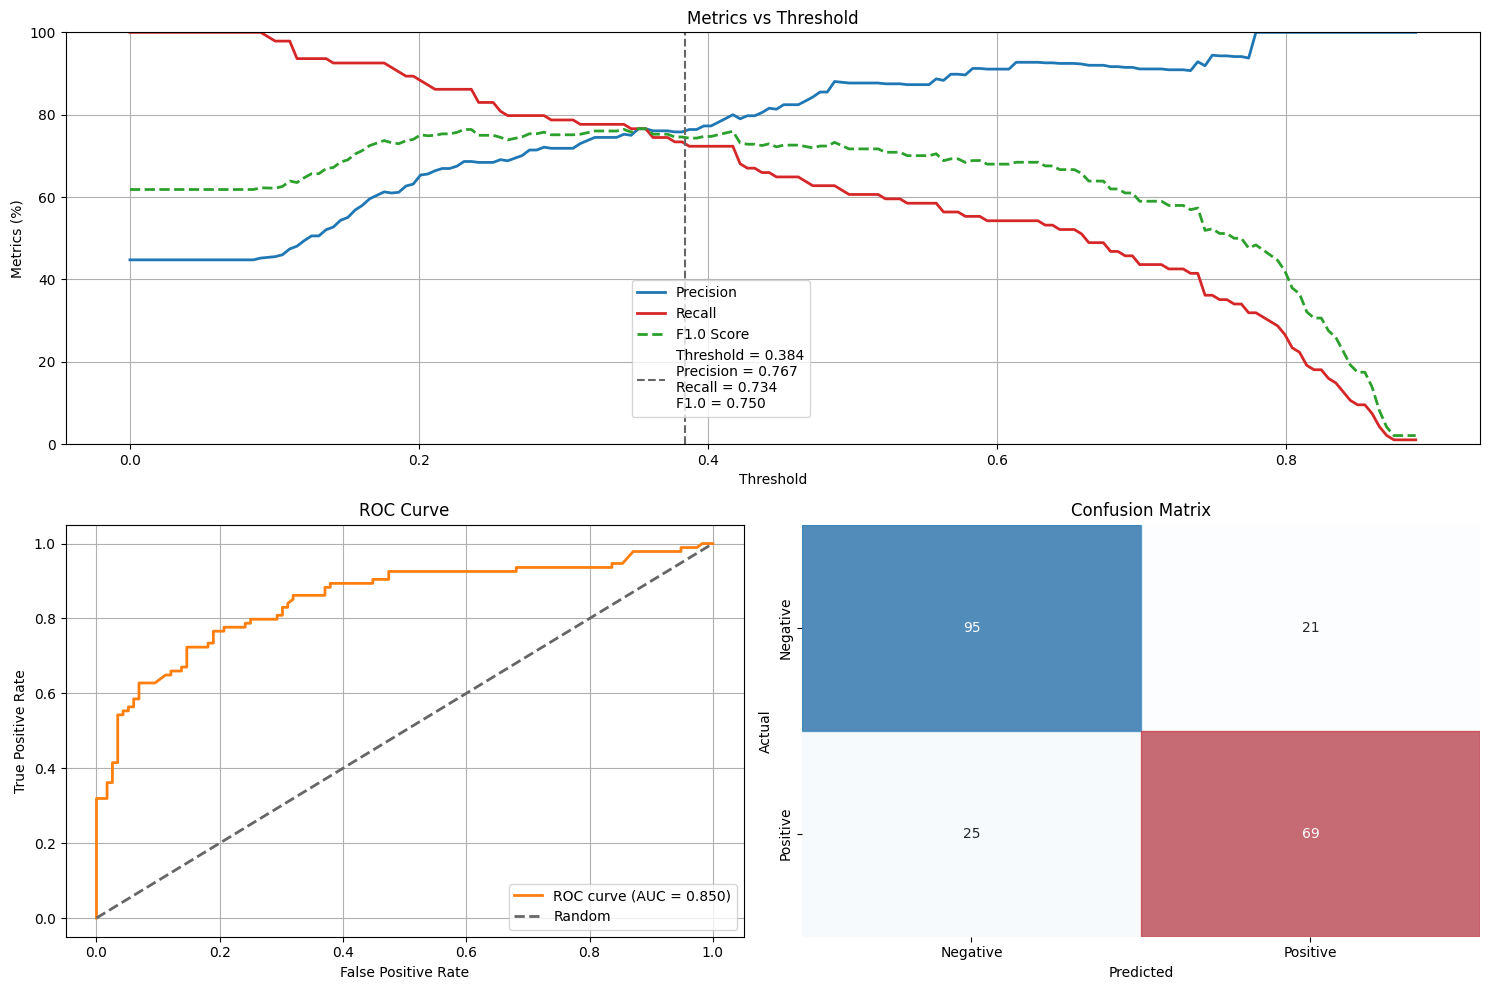


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.01180299207232919
n_estimators: 159
num_leaves: 53
max_depth: 14
colsample_bytree: 0.6756682847430403
subsample: 0.8503763107959509
Logging the best model to MLflow


2025/10/28 21:38:13 INFO mlflow.pyfunc: Validating input example against model signature



Hyperparameter Parallel Coordinate Plot:


In [23]:
best_lgb = MLPipeline.tune(X_train_full, y_train_full, 
                          algorithm=lgb.LGBMClassifier, 
                          preprocessor=PreProcessor(
                              target_encode_cols=encoding_recommendations["target_encode_cols"],
                          ),
                          param_ranges=lgb_param_ranges,  
                          beta=1,
                          max_evals=500,
                          early_stopping=50, 
                          n_startup_trials=10,
                          verbose=-1,
                          cv=5,
                          cv_variance_penalty=0.3,
                          log_best_model=True)


=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.384    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.767    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.794    (True positives / Predicted positives)
• Recall:      0.653    (True positives / Actual positives)
• F1 Score:    0.716    (Harmonic mean of Precision & Recall)
• MCC:         0.529    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.370    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


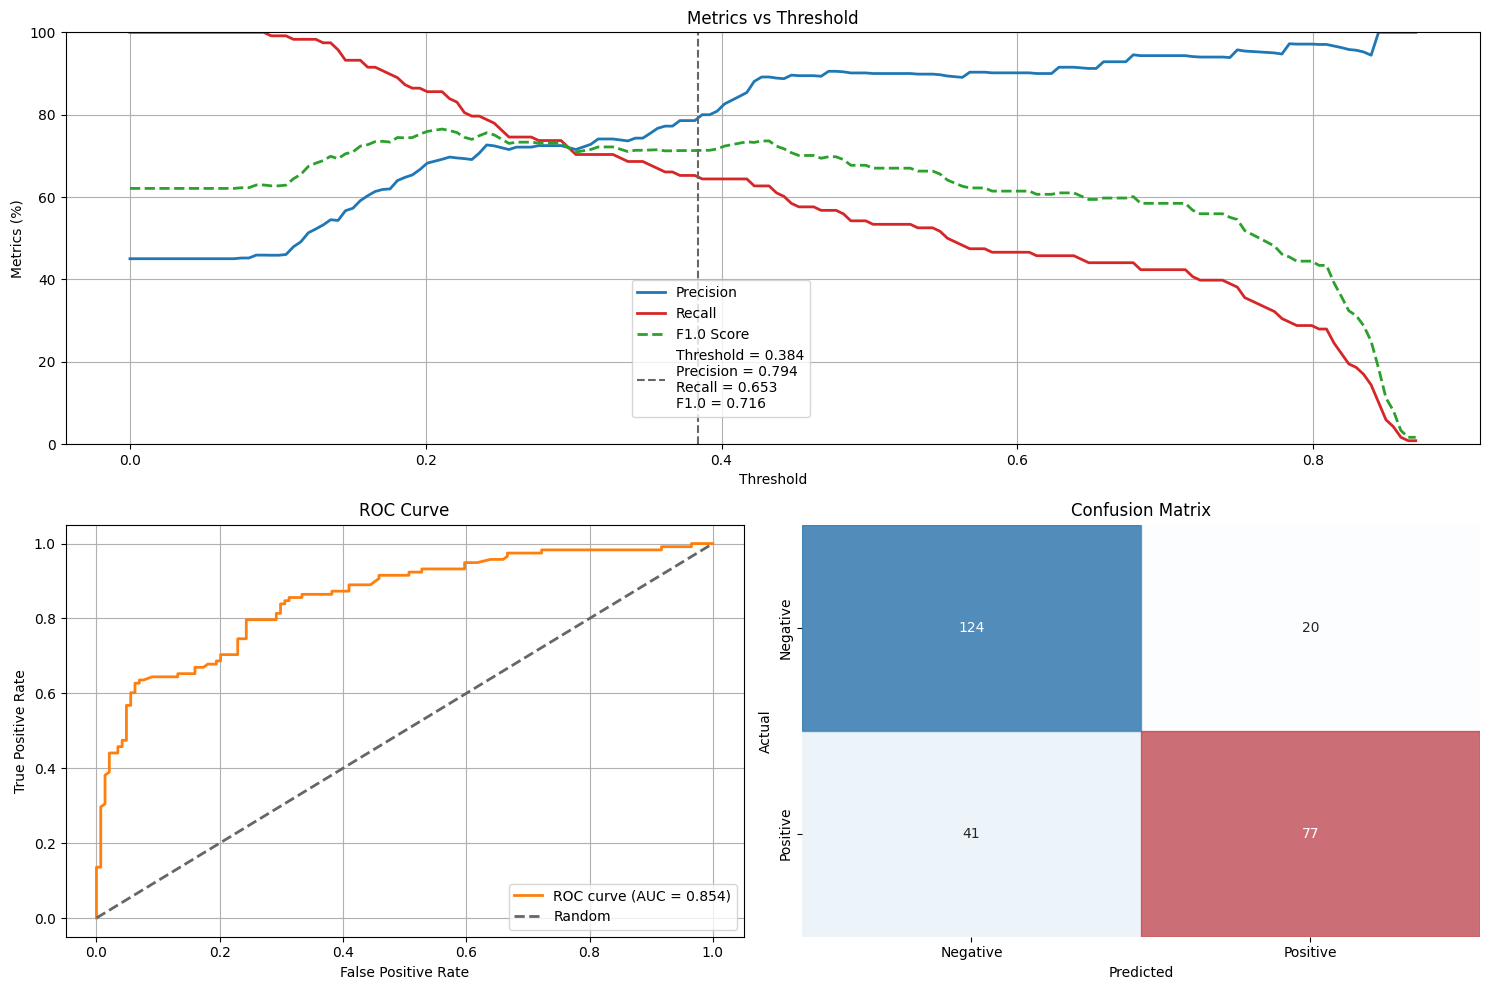

In [24]:
# extract the best model, evaluate with new data and understand its reasoning
best_pipeline = best_lgb['best_pipeline']
beta = best_lgb['beta']
optimal_threshold = best_lgb['optimal_threshold']
metrics = best_pipeline.evaluate(X_test, y_test, optimal_threshold, beta=beta, verbose=True)

## 4.2 Retrive the best model logged with Mlflow

In [25]:
model_info = best_lgb["model_info"]
print(model_info.utc_time_created)
print(model_info.run_id)
print(model_info.model_uri)
print(model_info.mlflow_version)

2025-10-28 10:38:13.825789
360763bc715b40a690c2bc31165fe1f1
runs:/360763bc715b40a690c2bc31165fe1f1/ml_pipeline
2.21.1



=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.384    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.767    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.794    (True positives / Predicted positives)
• Recall:      0.653    (True positives / Actual positives)
• F1 Score:    0.716    (Harmonic mean of Precision & Recall)
• MCC:         0.529    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.370    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


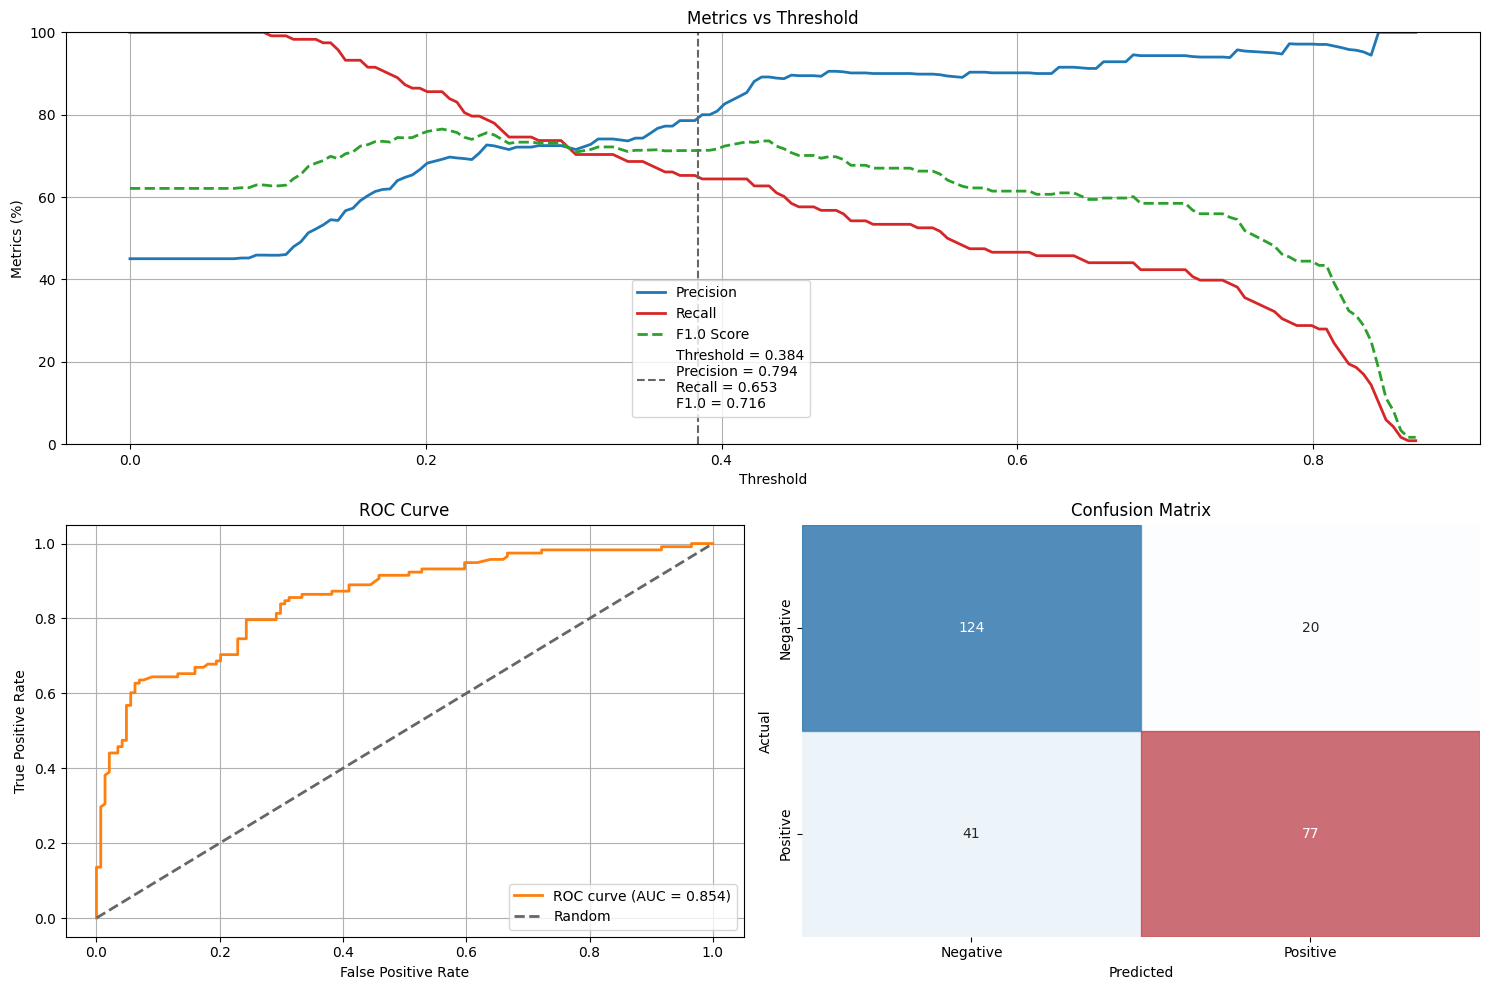

In [26]:
# loaded model
loaded_model = mlflow.pyfunc.load_model(model_info.model_uri)
# full function of the MLPipeline instance
unwrapped_model = loaded_model.unwrap_python_model()
run_id = loaded_model.metadata.run_id
run = mlflow.get_run(run_id)
beta = run.data.metrics['beta']
threshold = run.data.metrics['threshold']
results = unwrapped_model.evaluate(X_test, y_test, beta=beta, threshold=threshold)

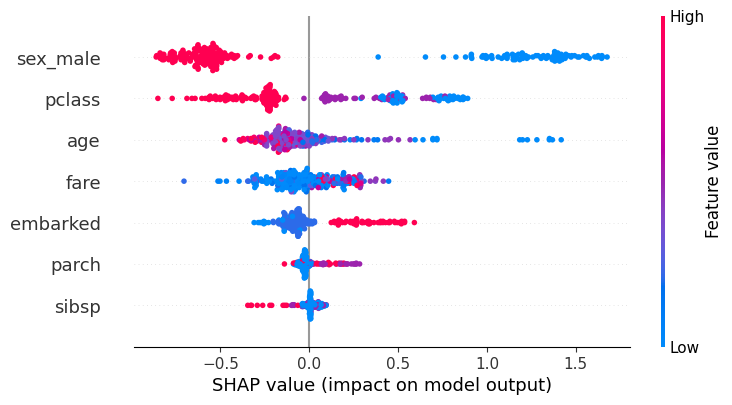

In [27]:
unwrapped_model.explain_model(X_test)

In [28]:
# prediction with loaded model directly
X_test_prepped = PreProcessor.mlflow_input_prep(X_test)
loaded_model.predict(pd.DataFrame(X_test_prepped.head()))

array([0.09476055, 0.34724818, 0.13104695, 0.10859491, 0.11127545])

## 4.3 Quick Demo for Alternative Metrics

We might want to choose different optimization goals for different use cases. Therefore, the `tune` method supports a wide range of target metrics (see below). To add another layer of complexity, when applying the `cv_variance_penalty` to promote robust models:
- For metrics being *maximized* (e.g., AUC), the effective score to optimize is mean *minus* `cv_varaince_penalty` * std_dev as shown above
- For metrics being *minimized* (e.g., RMSE), the effective score to optimize is mean *plus* `cv_varaince_penalty` * std_dev

Sound like a little bit of headache? 🤪 No worries! All you need to do is to set the desired tune_metric. The tune method automatically handles the correct optimization direction (maximization or minimization) and the appropriate application of the variance penalty. 😎 (please see 2.3 below for details)

The metrics the `tune` method can handle automatically for you include      
**For Classification:**
- `auc` (Area Under ROC Curve - default)   
- `f1` (F1 Score)   
- `accuracy` (Accuracy Score)   
- `log_loss` (Logarithmic Loss)   

**For Regression:**
- `rmse` (Root Mean Squared Error - default)   
- `mae` (Mean Absolute Error)   
- `median_ae` (Median Absolute Error)   
- `smape` (Symmetric Mean Absolute Percentage Error)   
- `nrmse_mean` (RMSE normalized by mean)  
- `nrmse_iqr` (RMSE normalized by Interquartile Range)  
- `nrmse_std` (RMSE normalized by Standard Deviation)  

##### 4.3.1 F1 as Tune Metric

  0%|          | 0/100 [00:00<?, ?it/s]

Best CV F1: 0.699(0.040)

Performance on holdout validation set:

=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.392    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.790    (Overall correct predictions)
• AUC:         0.856    (Ranking quality)
• Log Loss:    0.499    (Confidence-weighted error)
• Precision:   0.821    (True positives / Predicted positives)
• Recall:      0.681    (True positives / Actual positives)
• F1 Score:    0.744    (Harmonic mean of Precision & Recall)
• MCC:         0.576    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.371    (Fraction of positive predictions)
• Base Rate:   0.448    (Actual positive class rate)


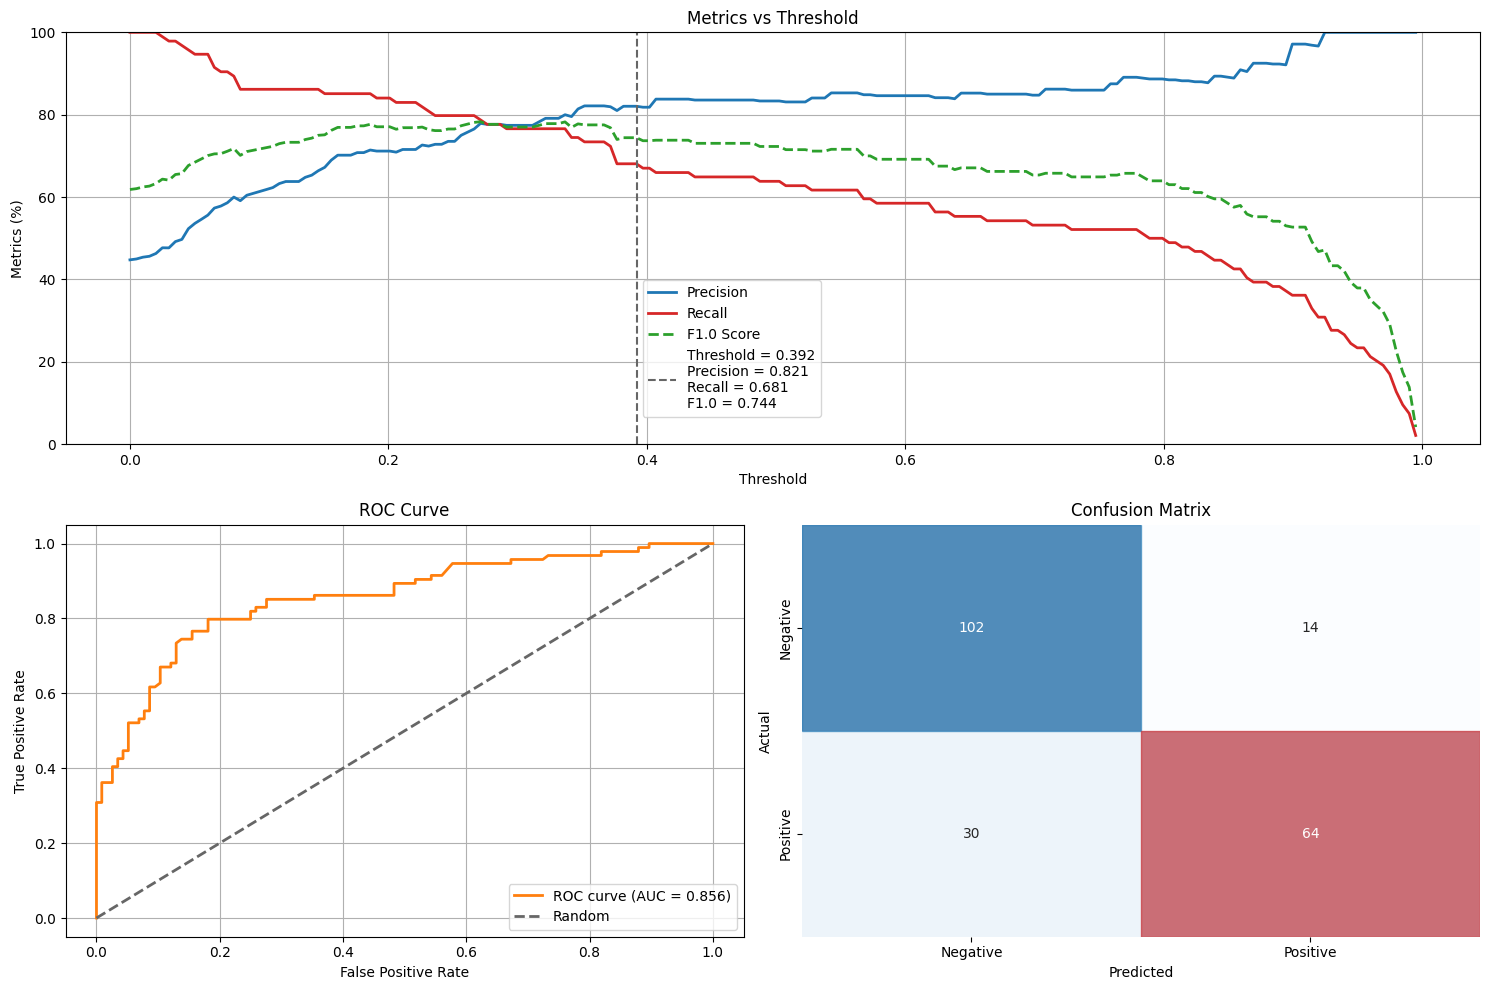


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.017476441002450948
n_estimators: 599
num_leaves: 61
max_depth: 6
colsample_bytree: 0.7814642143001149
subsample: 0.8658728336255487

Hyperparameter Parallel Coordinate Plot:


In [29]:
best_lgb_f1 = MLPipeline.tune(X_train_full, y_train_full, 
                          algorithm=lgb.LGBMClassifier, 
                          tune_metric='f1',
                          preprocessor=PreProcessor(
                              target_encode_cols=encoding_recommendations["target_encode_cols"],
                          ),
                          param_ranges=lgb_param_ranges,  
                          beta=1,
                          max_evals=100,
                          early_stopping=20,  
                          verbose=-1,
                          cv=3,
                          cv_variance_penalty=0.3,
                          log_best_model=False)

#### 4.3.2 Log Loss as Tune Metric

  0%|          | 0/100 [00:00<?, ?it/s]

Best CV LOG_LOSS: 0.436(0.025)

Performance on holdout validation set:

=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.407    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.805    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.463    (Confidence-weighted error)
• Precision:   0.805    (True positives / Predicted positives)
• Recall:      0.745    (True positives / Actual positives)
• F1 Score:    0.773    (Harmonic mean of Precision & Recall)
• MCC:         0.604    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.414    (Fraction of positive predictions)
• Base Rate:   0.448    (Actual positive class rate)


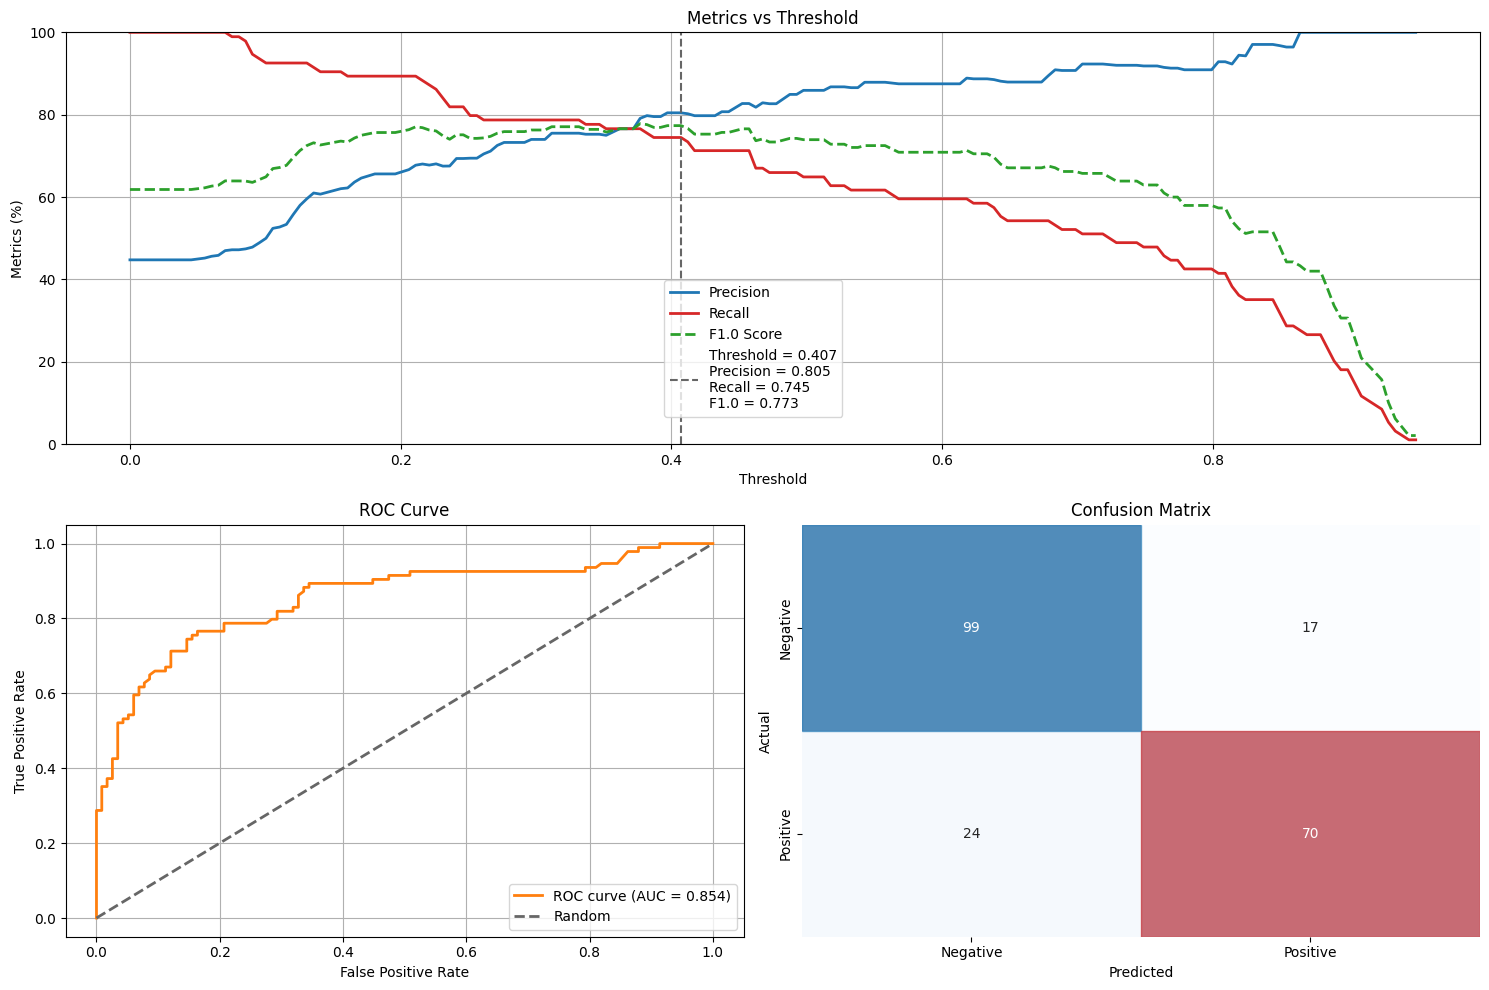


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.023147285775449715
n_estimators: 127
num_leaves: 98
max_depth: 7
colsample_bytree: 0.729825859224544
subsample: 0.8501442110497373

Hyperparameter Parallel Coordinate Plot:


In [30]:
best_lgb_log_loss = MLPipeline.tune(X_train_full, y_train_full, 
                          algorithm=lgb.LGBMClassifier, 
                          tune_metric='log_loss',
                          preprocessor=PreProcessor(
                              target_encode_cols=encoding_recommendations["target_encode_cols"],
                          ),
                          param_ranges=lgb_param_ranges,  
                          beta=1,
                          max_evals=100,
                          early_stopping=20,  
                          verbose=-1,
                          cv=3,
                          cv_variance_penalty=0.3,
                          log_best_model=False)

## 4.4 Quick Demo for Regressor Tuning

  0%|          | 0/100 [00:00<?, ?it/s]

Best CV SMAPE: 15.455(0.139)

Performance on holdout validation set:

=== Regression Metrics & Diagnostics ===

1. Error Metrics
----------------------------------------
• RMSE:         0.460      (Root Mean Squared Error)
• MAE:          0.303      (Mean Absolute Error)
• Median AE:    0.200      (Median Absolute Error)
• NRMSE Mean:   22.0%      (RMSE/mean)
• NRMSE Std:    39.2%      (RMSE/std)
• NRMSE IQR:    31.3%      (RMSE/IQR)
• MAPE:         16.6%      (Mean Abs % Error, excl. zeros)
• SMAPE:        15.4%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.847      (Coefficient of Determination)
• Adj. R²:      0.846      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      60.8%      (RMSE improvement)
• vs Median:    61.9%      (RMSE improvement)


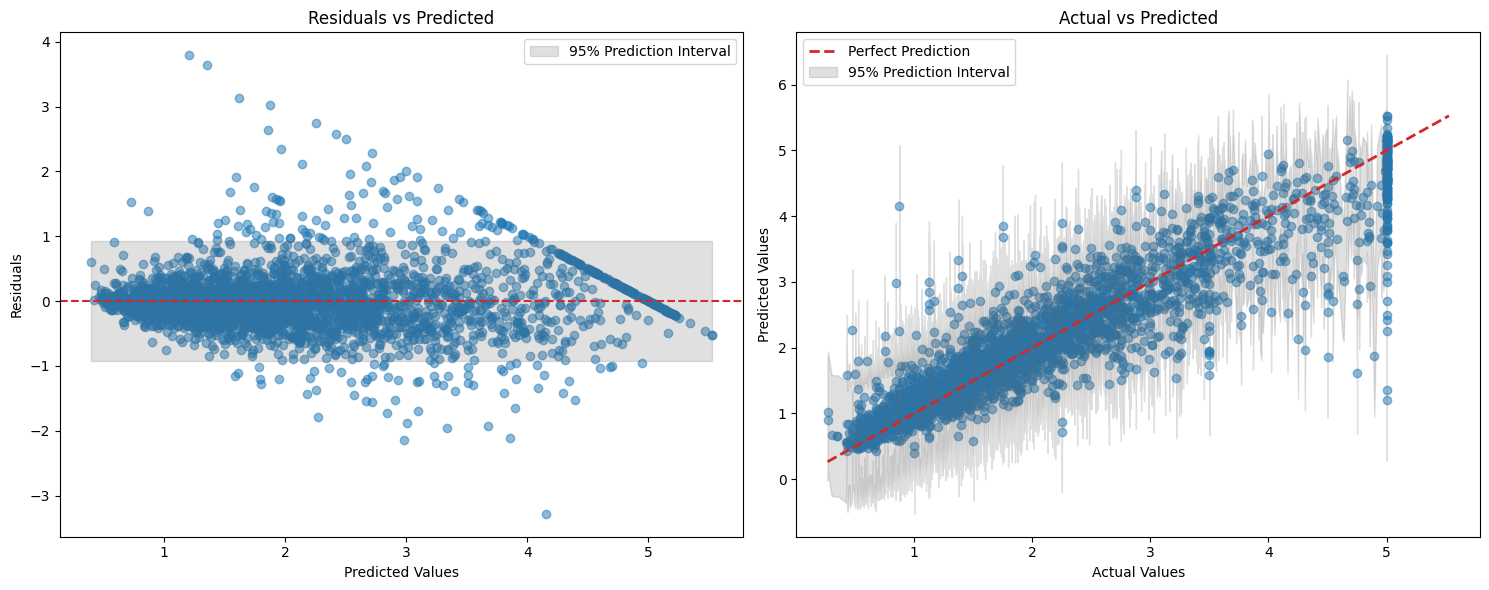


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.07142796391196558
n_estimators: 376
num_leaves: 43
max_depth: 14
colsample_bytree: 0.6916214194998337
subsample: 0.5549684709444044

Hyperparameter Parallel Coordinate Plot:


In [31]:
from sklearn.datasets import (
    fetch_california_housing
)
california = fetch_california_housing()
X_housing = pd.DataFrame(california.data, columns=california.feature_names)
X_housing = PreProcessor.mlflow_input_prep(X_housing)

y_housing = california.target
X_train_full_housing, X_test_housing, y_train_full_housing, y_test_housing = train_test_split(X_housing, y_housing, test_size=0.2, random_state=42)
# Define the hyperparameter search ranges
lgb_param_ranges = {
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (100, 500),   
    'num_leaves': (10, 50),
    'max_depth': (5, 15),
    'colsample_bytree': (0.5, 0.9),
    'subsample': (0.5, 0.9)
}
# tune the regressor
best_lgb_rgs = MLPipeline.tune(X_train_full_housing, y_train_full_housing, 
                          algorithm=lgb.LGBMRegressor, 
                          preprocessor=PreProcessor(),
                          param_ranges=lgb_param_ranges,  
                          tune_metric= "smape",
                          beta=1,
                          max_evals=100,
                          early_stopping=20,  
                          verbose=-1,
                          cv=3,
                          cv_variance_penalty=0.3,
                          log_best_model=False)

# 5. Threshold Analysis for Classification Models

In classification problems, there's an inherent trade-off between precision and recall. Different business scenarios may require different balances - fraud detection might prioritize precision to avoid false accusations, while medical screening might favor recall to catch all potential cases.

`mlarena` offers a `threshold_analysis` method that:
- Customizes precision-recall trade-offs through the beta parameter in F-beta score:
  - (1+β²)·(precision·recall)/(β²·precision+recall), specifically
  - When beta < 1: Precision is weighted more heavily
  - When beta = 1: Precision and recall are weighted equally (F1 score)
  - When beta > 1: Recall is weighted more heavily
- Finds the optimal classification threshold based on your business needs by maximizing F-beta 🎯
- Implements bootstrap method or stratified k-fold cross-validation for robust results

### 5.1 Threshold optimization in action

The demo below shows threshold optimization in action 🎯
1. Take a trained MLPipeline instance
    * which could be a best model from `tune` 
    * or a baseline model trained based on default config (see [1.basic_usage.ipynb](https://github.com/MenaWANG/mlarena/blob/master/examples/1.basic_usage.ipynb))
2. Use the train data to tune the optimal threshold using two methods:
    * Cross-validation method: splits data into folds to find robust threshold
    * Bootstrap method: resamples data with replacement for confidence intervals
    * Both methods allow setting beta parameter to balance precision vs recall
3. Compare results from both methods and their statistics
4. Apply the optimized thresholds to new data and evaluate performance

In [32]:
# take the best model identified, and identify the optimal threshold F0.8, which gives precision double the weight as recall
y_pred_proba = best_pipeline.predict(context=None, model_input = X_train_full)
results_cv = MLPipeline.threshold_analysis(y_train_full, y_pred_proba, beta = 0.8, cv_splits=3)
results_boot = MLPipeline.threshold_analysis(y_train_full, y_pred_proba, beta = 0.8, method = "bootstrap", bootstrap_iterations=100)
print(f"The optimizal threshold to maximize F0.8 from two methods respectively are CV: {results_cv['optimal_threshold']:.3f}, bootstrap: {results_boot['optimal_threshold']:.3f} ")


The optimizal threshold to maximize F0.8 from two methods respectively are CV: 0.422, bootstrap: 0.422 


In [33]:
# Detailed threshold statistics for both methods
print("\nCross-Validation Method Results:")
print(f"Optimal Threshold: {results_cv['optimal_threshold']:.4f}")
print(f"Threshold Std Dev: {results_cv['threshold_std']:.4f}")

print("\nBootstrap Method Results:")
print(f"Optimal Threshold: {results_boot['optimal_threshold']:.4f}")
print(f"Threshold Std Dev: {results_boot['threshold_std']:.4f}")
print(f"95% CI Lower: {results_boot['ci_lower']:.4f}")
print(f"95% CI Upper: {results_boot['ci_upper']:.4f}")


Cross-Validation Method Results:
Optimal Threshold: 0.4223
Threshold Std Dev: 0.0381

Bootstrap Method Results:
Optimal Threshold: 0.4223
Threshold Std Dev: 0.0381
95% CI Lower: 0.3522
95% CI Upper: 0.4967



=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.422    (Classification cutoff)
• Beta:        0.800    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.794    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.881    (True positives / Predicted positives)
• Recall:      0.627    (True positives / Actual positives)
• F1 Score:    0.733    (Harmonic mean of Precision & Recall)
• F0.8 Score:  0.761    (Weighted harmonic mean)
• MCC:         0.595    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.321    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


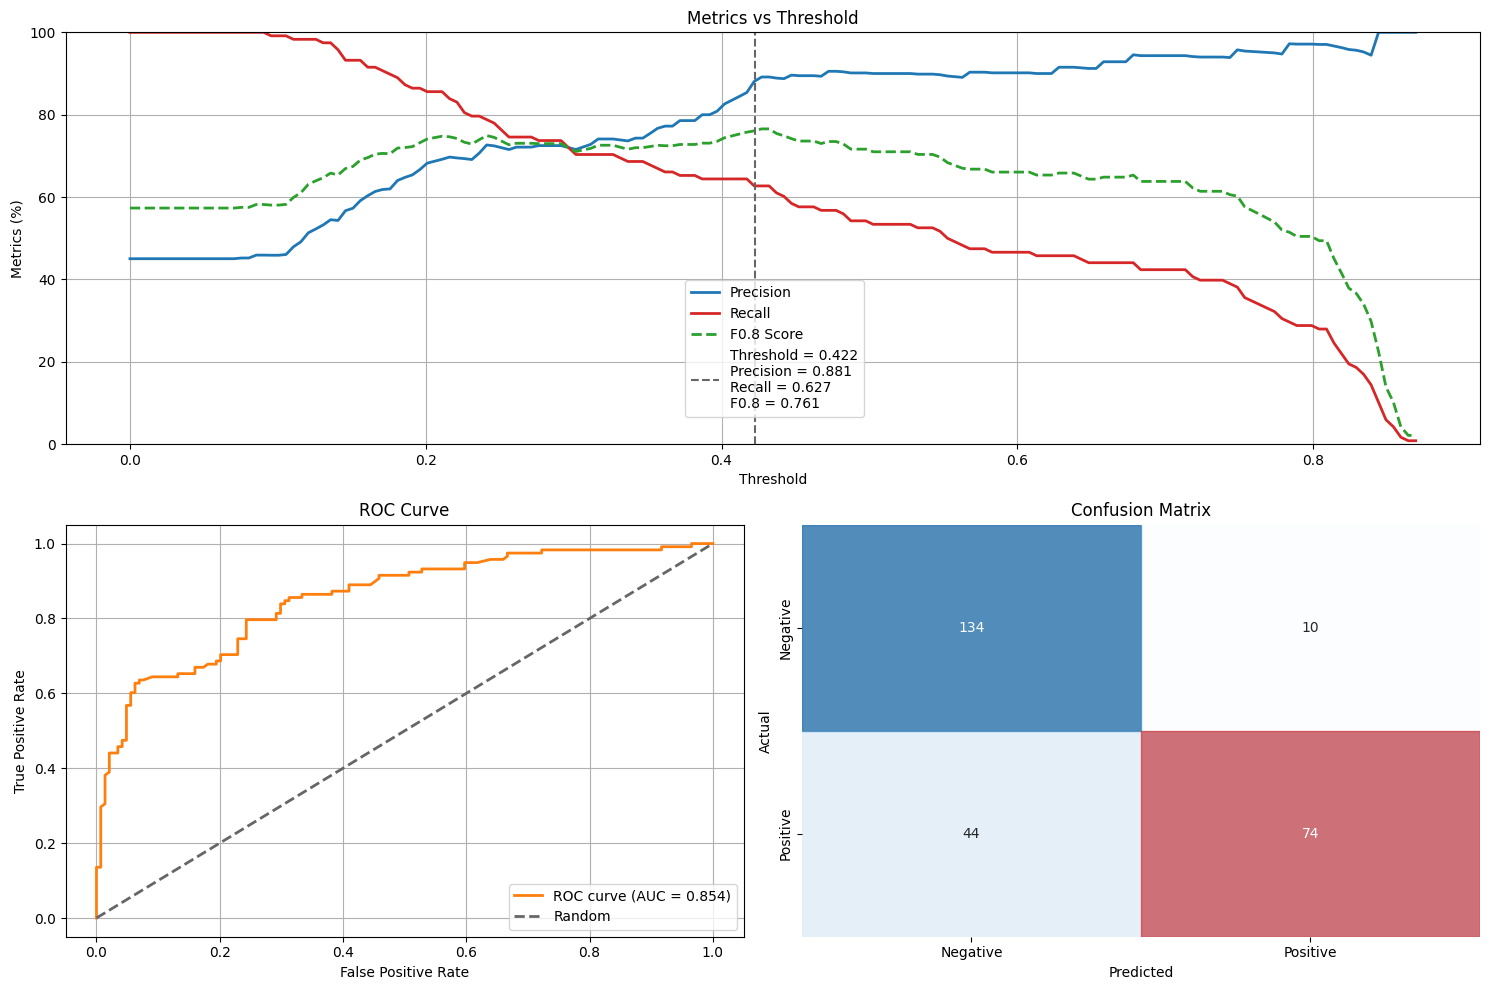

In [34]:
# utilize the optimal threshold identified
results = best_pipeline.evaluate(
    X_test, y_test, beta=0.8, 
    threshold=results_cv['optimal_threshold']
    )


=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.422    (Classification cutoff)
• Beta:        0.800    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.794    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.881    (True positives / Predicted positives)
• Recall:      0.627    (True positives / Actual positives)
• F1 Score:    0.733    (Harmonic mean of Precision & Recall)
• F0.8 Score:  0.761    (Weighted harmonic mean)
• MCC:         0.595    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.321    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


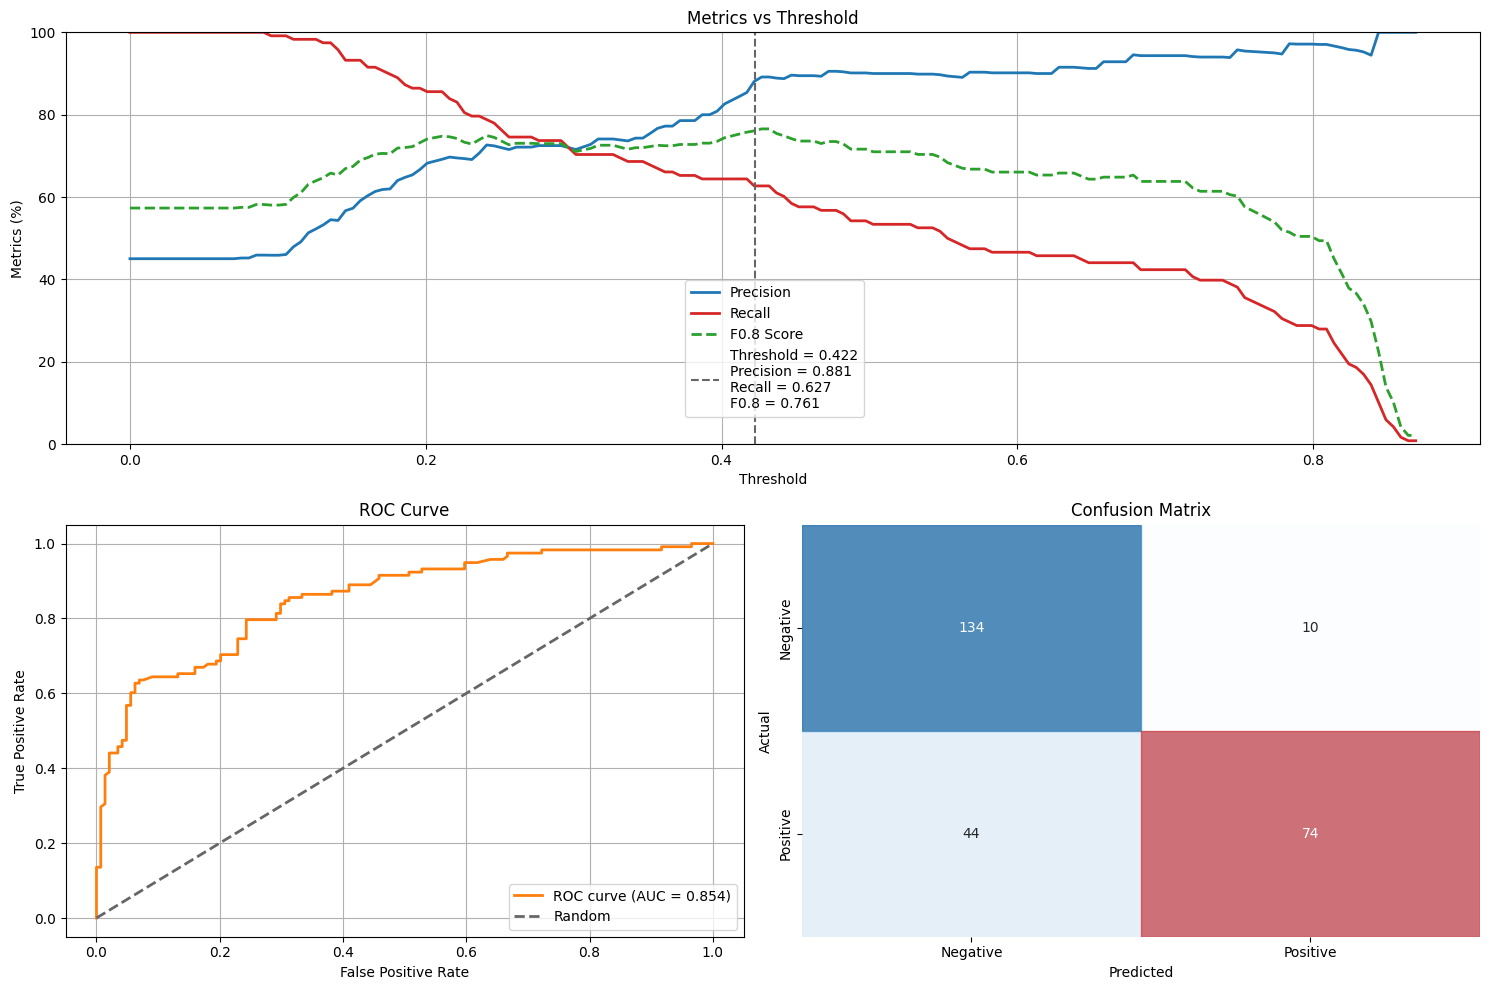

In [35]:
# performance of cv threshold
performance_cv = best_pipeline.evaluate(X_test, y_test, beta=0.8, threshold=results_cv['optimal_threshold'])


=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.422    (Classification cutoff)
• Beta:        0.800    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.794    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.881    (True positives / Predicted positives)
• Recall:      0.627    (True positives / Actual positives)
• F1 Score:    0.733    (Harmonic mean of Precision & Recall)
• F0.8 Score:  0.761    (Weighted harmonic mean)
• MCC:         0.595    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.321    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


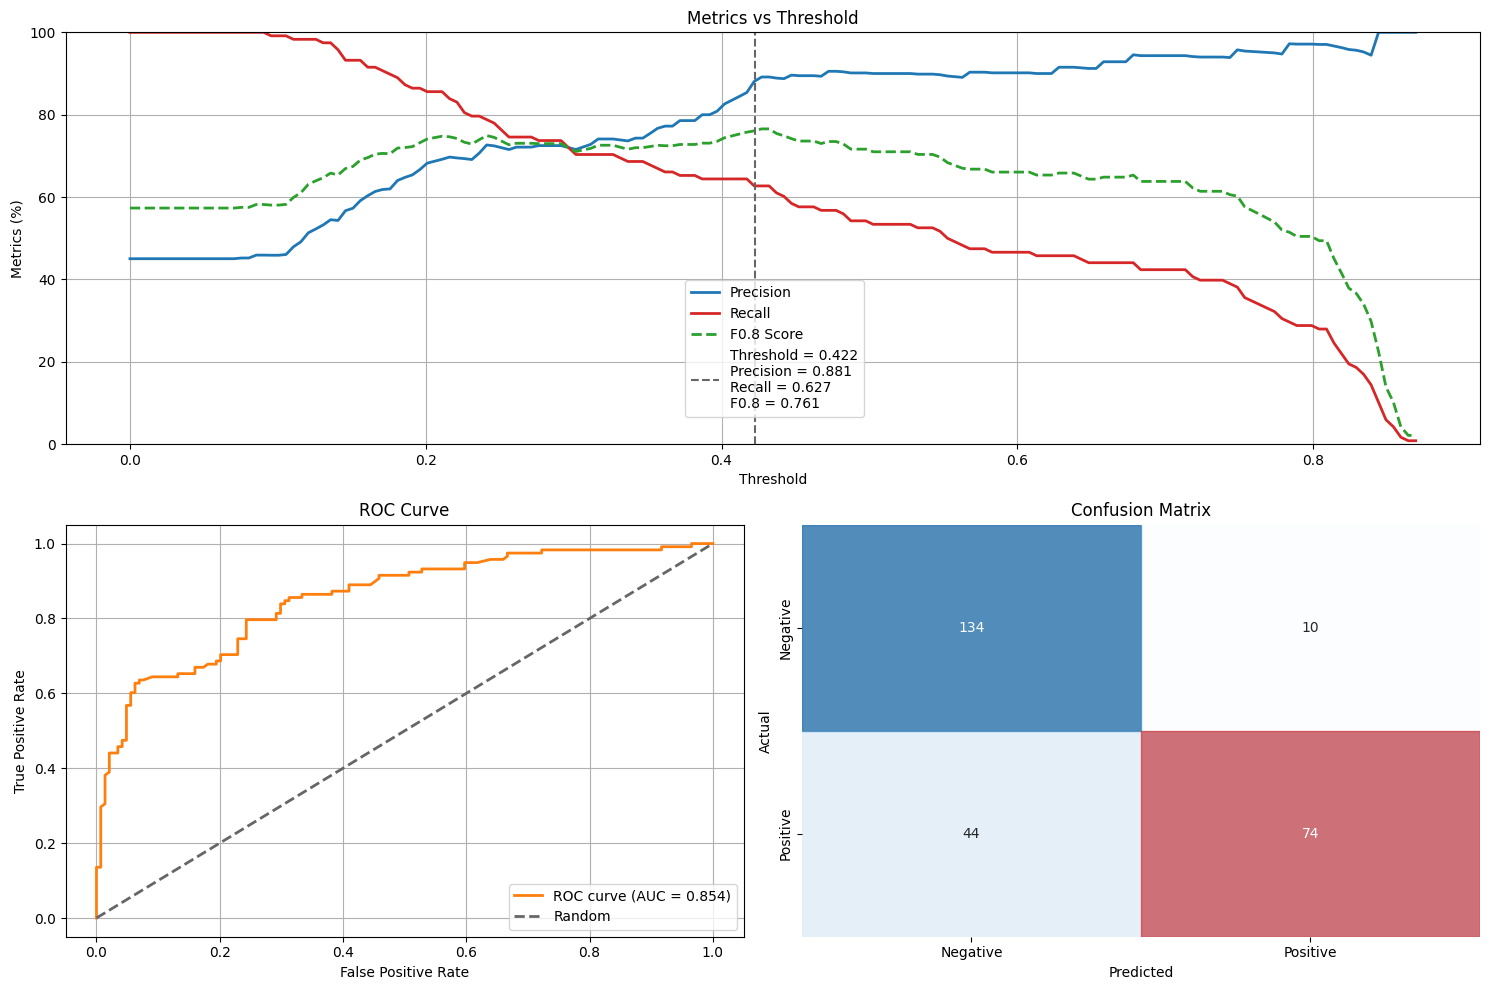

In [36]:
# performance of bootstrap threshold
performance_boot = best_pipeline.evaluate(X_test, y_test, beta=0.8, threshold=results_boot['optimal_threshold'])

### 5.2 Log and utilize the logged model

In [37]:
# log a model using the _log_model method directly
model_info = best_pipeline._log_model(
    metrics = performance_boot,
    params = best_pipeline.model.get_params(),
    sample_input=X_test.iloc[:1],
    sample_output=y_pred_proba[:1]
)

2025/10/28 21:39:56 INFO mlflow.pyfunc: Validating input example against model signature



=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.422    (Classification cutoff)
• Beta:        0.800    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.794    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.881    (True positives / Predicted positives)
• Recall:      0.627    (True positives / Actual positives)
• F1 Score:    0.733    (Harmonic mean of Precision & Recall)
• F0.8 Score:  0.761    (Weighted harmonic mean)
• MCC:         0.595    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.321    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


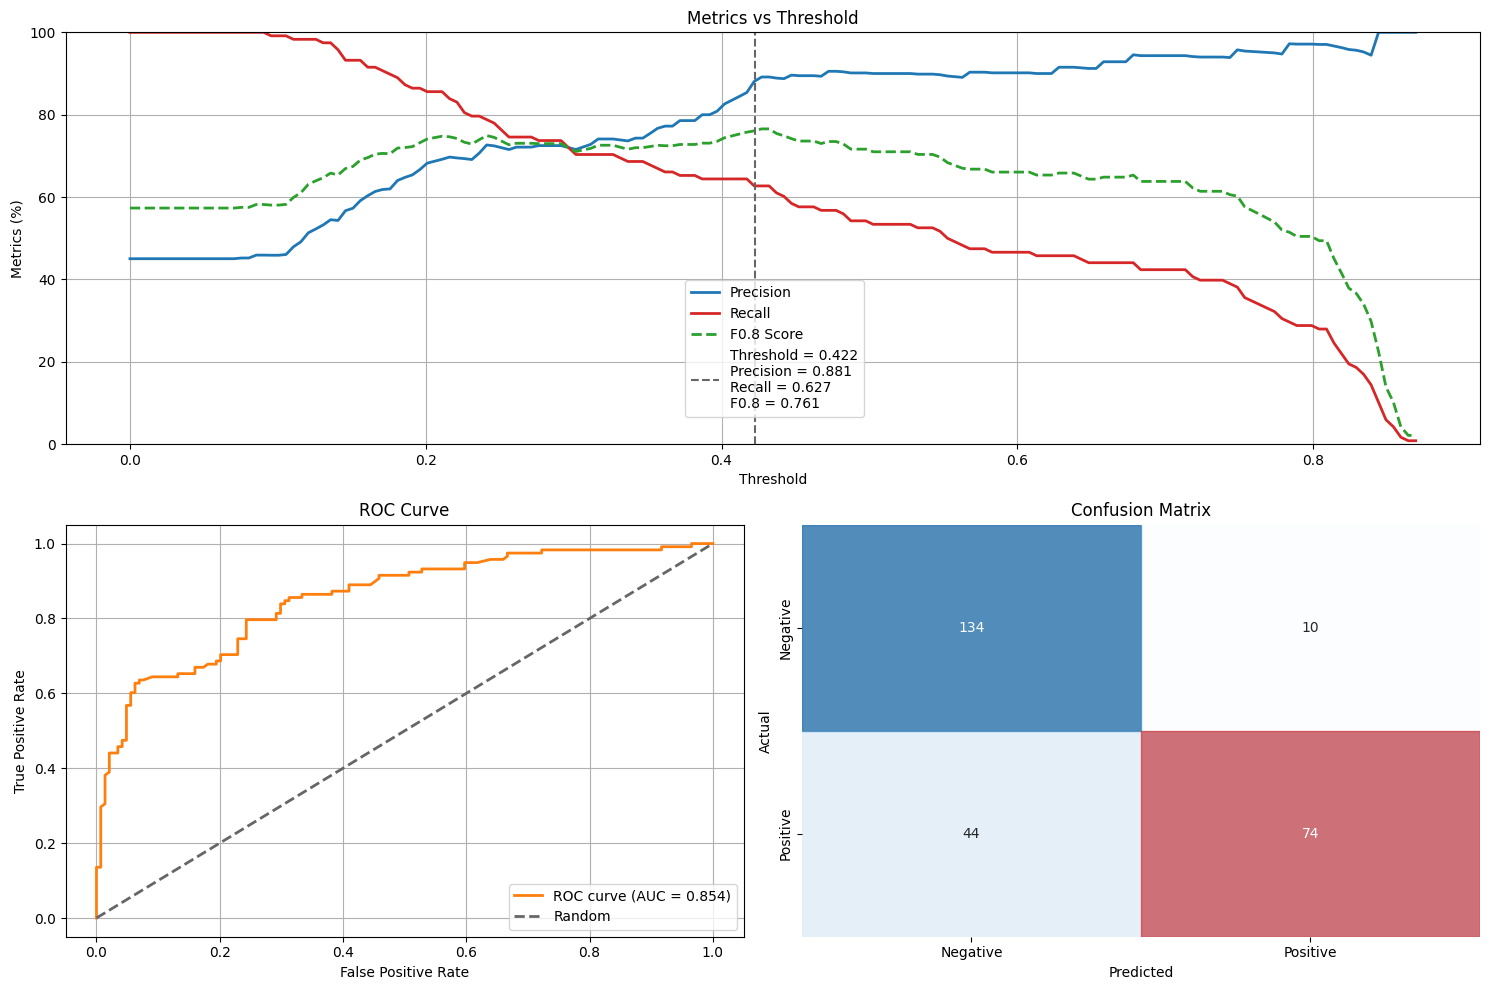

In [38]:
# load and utilize the logged model
loaded_model = mlflow.pyfunc.load_model(model_uri=model_info.model_uri) 
unwrapped_model = loaded_model.unwrap_python_model()
run = mlflow.get_run(model_info.run_id)
beta = run.data.metrics['beta']
threshold = run.data.metrics['threshold']
results = unwrapped_model.evaluate(X_test, y_test, beta=beta, threshold=threshold)


=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.200    (Classification cutoff)
• Beta:        0.800    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    0.756    (Overall correct predictions)
• AUC:         0.854    (Ranking quality)
• Log Loss:    0.503    (Confidence-weighted error)
• Precision:   0.682    (True positives / Predicted positives)
• Recall:      0.856    (True positives / Actual positives)
• F1 Score:    0.759    (Harmonic mean of Precision & Recall)
• F0.8 Score:  0.741    (Weighted harmonic mean)
• MCC:         0.531    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.565    (Fraction of positive predictions)
• Base Rate:   0.450    (Actual positive class rate)


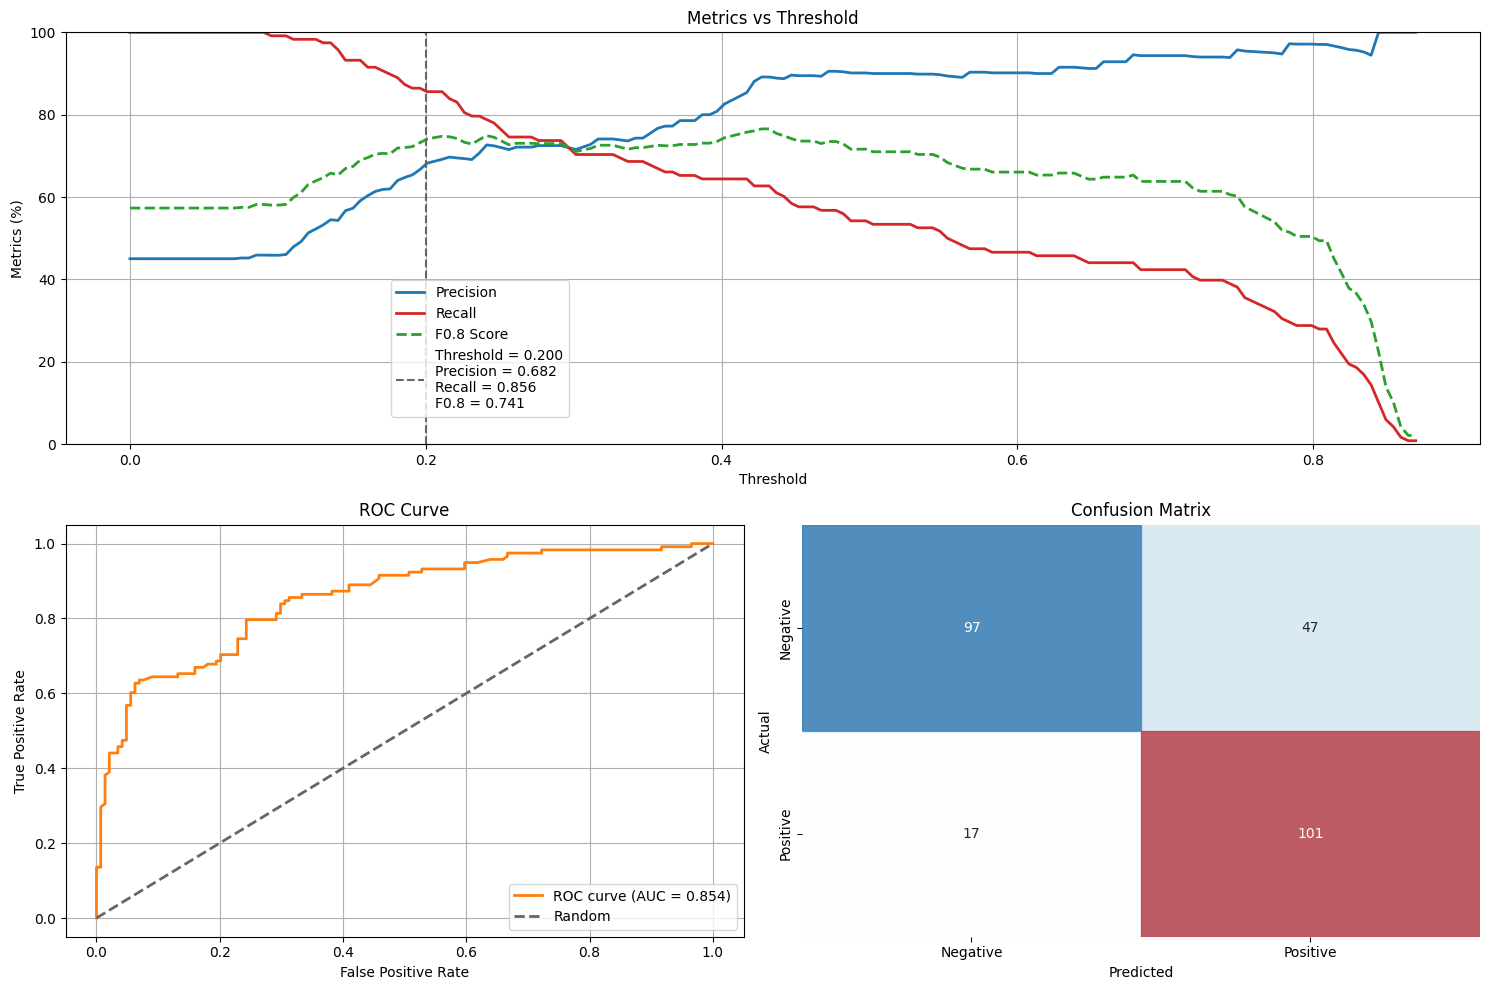

In [39]:
# update report with any specified threshold
results = unwrapped_model.evaluate(X_test, y_test, beta=beta, threshold=0.2)

# 6. Wrapper Feature Selection

MLArena provides a handy wrapper-based feature selection method using Recursive Feature Elimination with Cross-Validation (RFECV). This technique iteratively removes features, evaluating subsets based on the predictive performance of a chosen machine learning model.

**Key Features**:
- Works seamlessly for both classification and regression tasks
- Incorprate variance penalty to encourage robust, stable feature selection
- Provides detailed visualization of the selection process where user can see both the mean performance and the variance
    - The main blue line represents the mean CV score for each feature count
    - The error bars show ±1 standard deviation
    - The green dashed line represents the penalized score (mean - penalty * std) 
- `n_max_features`  
    - can be set by the user, but when left unspecified, default to be n_samples/10
    - This is especially useful when working with small datasets, where users need to restrict the number of features to prevent overfitting

**Parameters Overview**:
- `X`: Feature matrix
- `y`: Target variable
- `estimator`: Base estimator (defaults to RandomForestClassifier/Regressor)
- `n_max_features`: Maximum number of features to select (default: n_samples/10)
- `cv_variance_penalty`: Penalty factor for feature variance (default: 0.1)
- `cv`: Cross-validation strategy (default: 5)
- `scoring`: Scoring metric (if not specified, use estimator's default scoring. 
- `verbose`: Controls output verbosity
- `random_state`: For reproducibility

## 6.1 Use Independently: Classification

Wrapper Feature Selection Summary:
Task type: classification
Total features analyzed: 7
Maximum features considered: 7
Optimal features selected: 6
Optimal CV score: 0.8296 (±0.0287)
Penalized score: 0.8268
Selected features: ['pclass', 'sex', 'age', 'sibsp', 'fare', 'embarked']


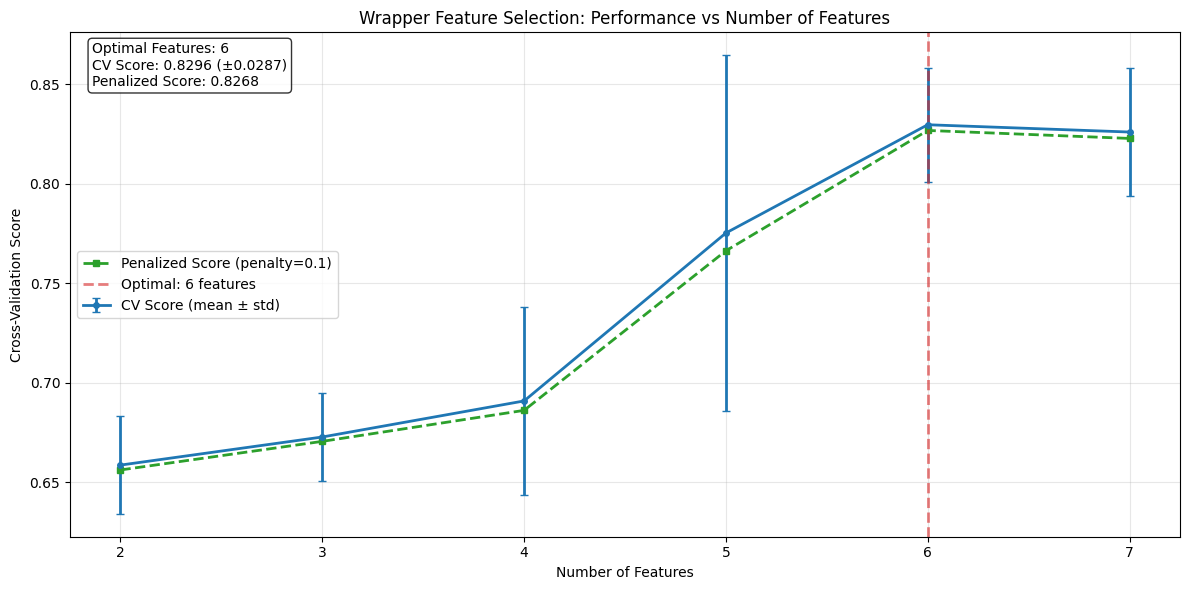

In [40]:
clf_results = PreProcessor.wrapper_feature_selection(
    X=X_train,
    y=y_train,
    model=lgb.LGBMClassifier(),
    n_max_features=8,
    cv_variance_penalty=0.1,
    verbose=True,
    random_state=42,
    visualize=True,
)

Wrapper Feature Selection Summary:
Task type: classification
Total features analyzed: 7
Maximum features considered: 7
Optimal features selected: 6
Optimal CV score: 0.6783 (±0.0395)
Penalized score: 0.6743
Selected features: ['pclass', 'sex', 'age', 'sibsp', 'fare', 'embarked']


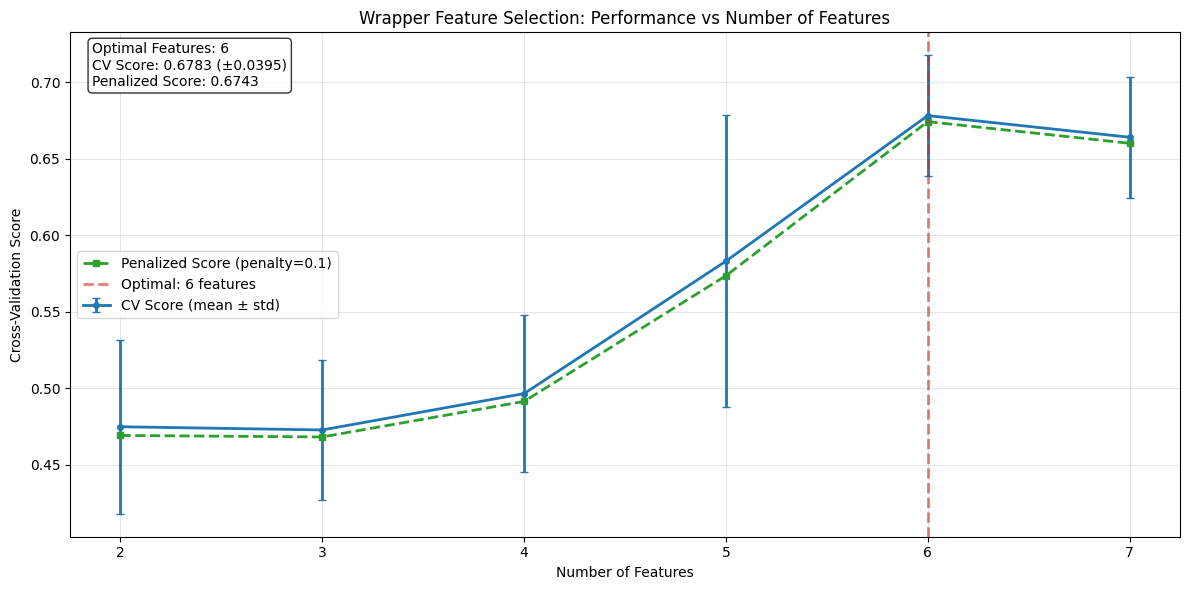

In [41]:
clf_results = PreProcessor.wrapper_feature_selection(
    X=X_train,
    y=y_train,
    model=lgb.LGBMClassifier(),
    n_max_features=8,
    cv_variance_penalty=0.1,
    verbose=True,
    random_state=42,
    visualize=True,
    scoring = 'f1' 
)

In [42]:
clf_results['selected_features']

['pclass', 'sex', 'age', 'sibsp', 'fare', 'embarked']

## 6.2 Use Independently: Regressions

In [43]:
# Load data
california = fetch_california_housing()
X = pd.DataFrame(california.data, columns=california.feature_names)
X = PreProcessor.mlflow_input_prep(X)

y = pd.Series(california.target)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Wrapper Feature Selection Summary:
Task type: regression
Total features analyzed: 8
Maximum features considered: 8
Optimal features selected: 7
Optimal CV score: -0.4692 (±0.0139)
Penalized score: -0.4706
Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


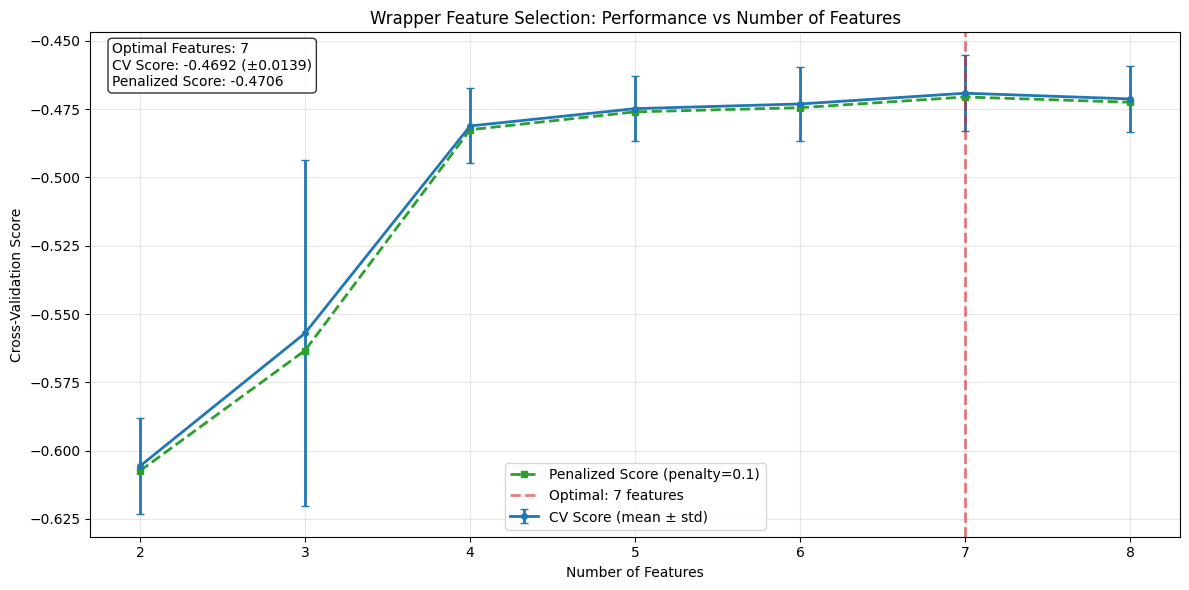

In [44]:
wfs_results = PreProcessor.wrapper_feature_selection(
    X=X_train,
    y=y_train,
    model=lgb.LGBMRegressor(),
    n_max_features=8,
    cv_variance_penalty=0.1,
    verbose=True,
    random_state=42,
    visualize=True,
)

Wrapper Feature Selection Summary:
Task type: regression
Total features analyzed: 8
Maximum features considered: 8
Optimal features selected: 7
Optimal CV score: -0.3134 (±0.0083)
Penalized score: -0.3142
Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


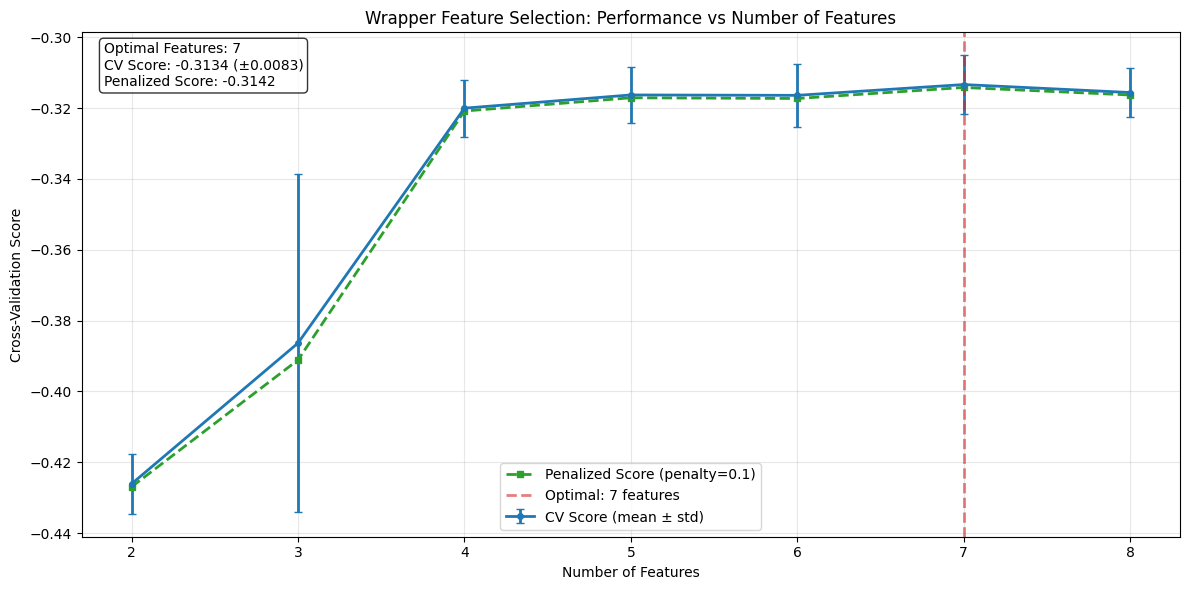

In [45]:
wfs_results = PreProcessor.wrapper_feature_selection(
    X=X_train,
    y=y_train,
    model=lgb.LGBMRegressor(),
    n_max_features=8,
    cv_variance_penalty=0.1,
    verbose=True,
    random_state=42,
    visualize=True,
    scoring='neg_mean_absolute_error'    
)

## 6.3 Specify CV Method

By default, `wrapper_feature_selection` uses `KFold` for regression and `StratifiedKFold` for classification tasks. 
You can also pass a custom scikit-learn CV splitter, such as `TimeSeriesSplit` or `GroupKFold`, to the `cv` parameter if desired.

Wrapper Feature Selection Summary:
Task type: regression
Total features analyzed: 8
Maximum features considered: 8
Optimal features selected: 7
Optimal CV score: -0.3132 (±0.0054)
Penalized score: -0.3137
Selected features: ['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


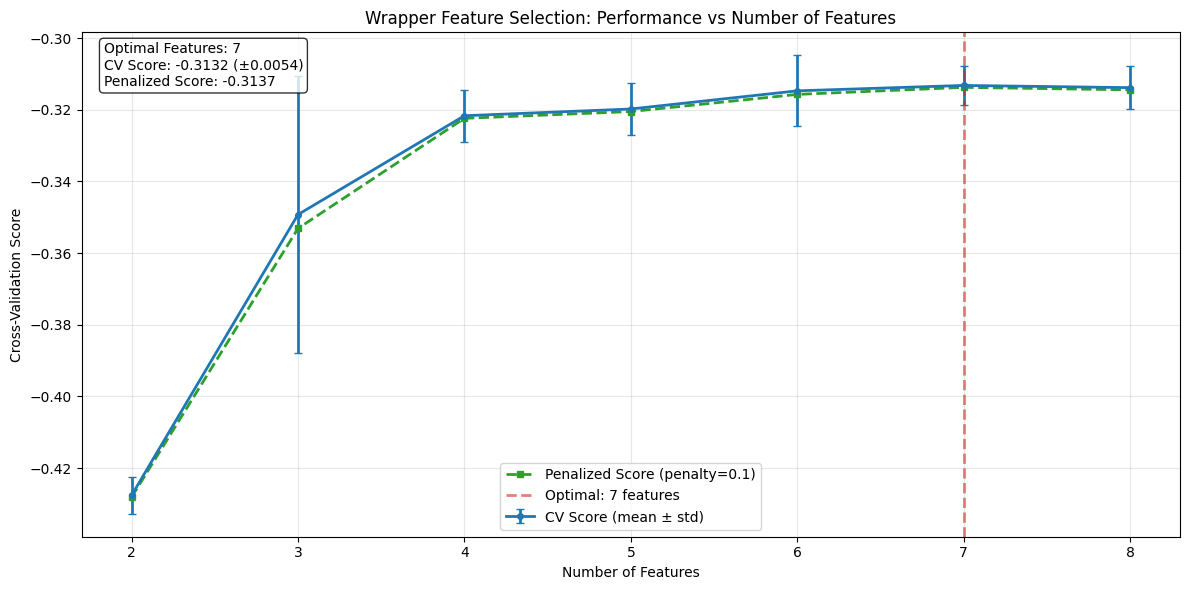

In [46]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=5, shuffle=False)

wfs_results = PreProcessor.wrapper_feature_selection(
    X=X_train,
    y=y_train,
    cv = cv,
    model=lgb.LGBMRegressor(),
    n_max_features=8,
    cv_variance_penalty=0.1,
    verbose=True,
    random_state=42,
    visualize=True,
    scoring='neg_mean_absolute_error'    
)

## 6.4 Integrated with Tune Method

To integrate with the tune method, simply pass the selected features, instead of the full set into the `tune` method. 

In [47]:
selected_features = wfs_results["selected_features"]
print(selected_features)

['MedInc', 'HouseAge', 'AveRooms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [48]:
lgb_param_ranges = {
    'learning_rate': (0.01, 0.1),  
    'n_estimators': (100, 1000),   
    'num_leaves': (20, 100),
    'max_depth': (5, 15),
    'colsample_bytree': (0.6, 1.0),
    'subsample': (0.6, 0.9)
}

  0%|          | 0/500 [00:00<?, ?it/s]

Best CV RMSE: 0.447(0.007)

Performance on holdout validation set:

=== Regression Metrics & Diagnostics ===

1. Error Metrics
----------------------------------------
• RMSE:         0.461      (Root Mean Squared Error)
• MAE:          0.298      (Mean Absolute Error)
• Median AE:    0.188      (Median Absolute Error)
• NRMSE Mean:   22.0%      (RMSE/mean)
• NRMSE Std:    39.2%      (RMSE/std)
• NRMSE IQR:    31.3%      (RMSE/IQR)
• MAPE:         16.3%      (Mean Abs % Error, excl. zeros)
• SMAPE:        15.1%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.846      (Coefficient of Determination)
• Adj. R²:      0.846      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      60.8%      (RMSE improvement)
• vs Median:    61.8%      (RMSE improvement)


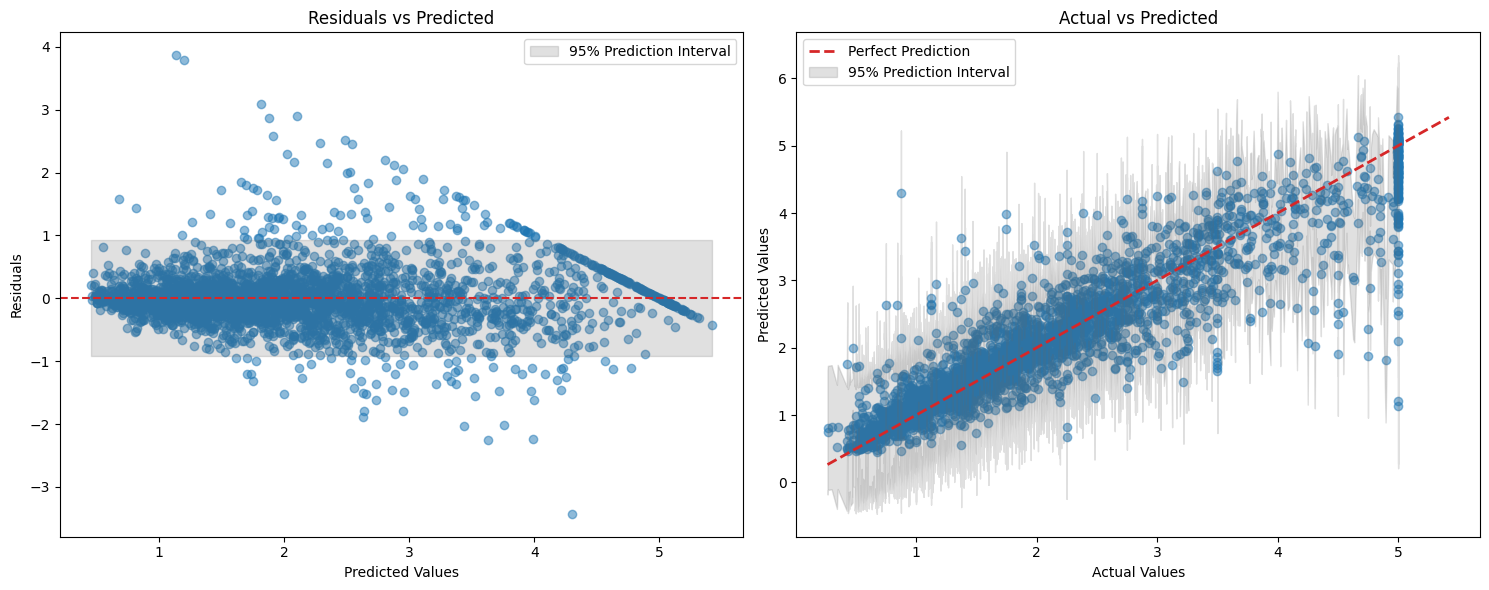


Hyperparameter Tuning Results

Best parameters found:
learning_rate: 0.041587427155510975
n_estimators: 540
num_leaves: 66
max_depth: 13
colsample_bytree: 0.6919268357610656
subsample: 0.762935156627247

Hyperparameter Parallel Coordinate Plot:


In [49]:
best_lgb = MLPipeline.tune(X_train[selected_features], y_train, 
                          algorithm=lgb.LGBMRegressor, 
                          preprocessor=PreProcessor(),
                          param_ranges=lgb_param_ranges,  
                          verbose=-1,
                          cv=5,
                          cv_variance_penalty=0.5,
                          log_best_model=False)

# 7. Little Delights

Here we demo some little delights that make an ML practitioner's life so much easier! 🤗 Think of these as a collection of ML quality-of-life improvements - like having a cup holder in exactly the right spot ☕, or finding out your new jacket has inside pockets. Small things that make you smile 😊. 

## 7.1 Feature Name Sanitization for ML Pipelines

The `PreProcessor` includes intelligent **feature name sanitization** that automatically converts problematic special characters in categorical feature names into ML-pipeline-friendly alternatives. This extra sanitization layer eliminates a common source of production failures when dealing with real-world categorical data. 

When categorical features get one-hot encoded, sklearn's `OneHotEncoder` preserves original categorical values in feature names (e.g., `category_A`, `state_victoria`), which is very helpful in most situations, but can cause compatibility issues for downstream ML tools when categorical values contain special characters like `"age_60+"`, `"category_A&B"`, or `"income_<$30K"`. 

`PreProcessor` can automatically convert these problematic characters when users set `sanitize_feature_names` parameter to be True. 

**Key Features/Benefits**:

• **Production ready names**: Converts problematic characters to safe alternatives to prevent pipeline failures.
• **Semantic Preservation** - Maintains meaning where possible:
  - `60+` → `60_plus` (range indicators)
  - `<$30K` → `lt_30K` (comparisons) 
  - `50%` → `50_pct` (percentages)
• **Clean, readable names** - Separators become simple underscores:
  - `A&B` → `A_B` 
  - `Type/1` → `Type_1`
  - `X|Y` → `X_Y`
• **Zero configuration** - Enabled by default with `sanitize_feature_names=True`, easily disabled if raw names are preferred
• **Comprehensive coverage** - Handles any special character automatically while applying intelligent rules for common mathematical symbols

In [50]:
X = pd.DataFrame(
    {
        "numeric": [1, 2, 3, 4],
        "age_group": ["18-25", "60+", "18-25", "60+"],  # Test dash and plus
        "income_range": ["<$30K", "<$30K", ">$100K", "30K-100K"],  # Test <, >, +, -
        "category": ["A&B", "Grade*", "A&B", "Grade*"],  # Test &, |, /, *
    }
)
y = pd.Series([0, 1, 0, 1])


In [51]:
preprocessor = PreProcessor(sanitize_feature_names=True, drop=None)
X_preprocessed = preprocessor.fit_transform(X) 
X_preprocessed.columns

Index(['numeric', 'age_group_18_25', 'age_group_60_plus',
       'income_range_30K_100K', 'income_range_lt_30K', 'income_range_gt_100K',
       'category_A_B', 'category_Grade'],
      dtype='object')

In the code chunk below, you can test any feature name of interests and see whether they are sanitized in expected ways. Simply put the `original` and `sanitized` in a pair like below, for example `("feature_18-25", "feature_18_25")`

| Original Feature Name | Sanitized Name | Note |
|---------------------|----------------|------|
| `feature_18-25` | `feature_18_25` | Dash to underscore |
| `income_<$30K` | `income_lt_30K` | `<` becomes `lt` |
| `percent_50%` | `percent_50_pct` | `%` becomes `pct` |
| `range_60+` | `range_60_plus` | `+` becomes `plus` |
| `score_X=Y` | `score_X_eq_Y` | `=` becomes `eq` |
| `category_A&B` | `category_A_B` | Special chars to underscore |
| `multiple__under___scores` | `multiple_under_scores` | Clean up multiple underscores |
| `__leading_trailing__` | `leading_trailing` | Strip leading/trailing underscores |

In [52]:
# Test any cases of interests with "orignal", "expected sanitized"
test_cases = [
    ("feature_18-25", "feature_18_25"),  # dash
    ("income_<$30K", "income_lt_30K"),  # < at start
    ("range_18<25", "range_18_lt_25"),  # < between values  
    ("product_Basic*", "product_Basic"),  # * → underscore
    ("category_A&B", "category_A_B"),  # & → underscore
    ("type_X|Y", "type_X_Y"),  # | → underscore
    ("path_Type/1", "path_Type_1"),  # / → underscore
    ("percent_50%", "percent_50_pct"),  # % (semantic)
    ("range_60+", "range_60_plus"),  # + (semantic)
    ("score_X=Y", "score_X_eq_Y"),  # = between values
    ("special_@#$", "special"),  # multiple special chars
    ("multiple__under___scores", "multiple_under_scores"),  # cleanup
    ("__leading_trailing__", "leading_trailing"),  # strip
]

   
print("🧪 Testing sanitization rules...")
successes = 0
for original, expected in test_cases:
    result = PreProcessor._sanitize_feature_names([original])[0]
    assert result == expected, f"Failed: {original} → {result} (expected: {expected})"
    successes += 1
    
print(f"✅ All {successes}/{len(test_cases)} tests passed!")



🧪 Testing sanitization rules...
✅ All 13/13 tests passed!


## 6.2 Enhanced Model Evaluation Diagnostics

**Intelligent Warnings That Make You a Better ML Practitioner**

Machine learning models can fail silently in production, often due to data quality issues or methodological problems that aren't immediately obvious from standard metrics alone. That's why we've enhanced `MLPipeline`'s evaluation capabilities with intelligent diagnostic warnings that automatically detect common pitfalls and guide you toward more robust model development.

**🎯 Why This Matters**: Even experienced data scientists can miss critical issues that compromise model reliability:

- **Overfitting risks** from insufficient training data relative to feature count
- **Data leakage** that creates unrealistically perfect performance
- **Class imbalance** that makes standard metrics misleading  
- **Metric limitations** where calculations exclude important data points
- **Statistical validity** issues that make model comparisons meaningless

**🚀 What You Get**: Our enhanced diagnostics act as your **AI safety net**, automatically catching these issues before they become production problems. The evaluation report now includes an intelligent **Model Evaluation Diagnostics** section that only appears when issues are detected. No more cluttered output when your model is healthy!

**Regression Diagnostics**
- **⚠️ Sample-to-feature ratio warnings**: Alerts when n/k < 10, indicating high overfitting risk
- **ℹ️ MAPE transparency**: Reports how many observations were excluded from MAPE due to zero target values  

**Classification Diagnostics**  
- **⚠️ Data leakage detection**: Flags near-perfect AUC (>99%) that often indicates leakage
- **⚠️ Overfitting alerts**: Same n/k ratio warnings as regression
- **ℹ️ Class imbalance awareness**: Flags severely imbalanced class distributions

**📊 Demo Examples**: The following demonstrations show these diagnostics in action with both classification and regression scenarios designed to trigger various warnings. You'll see how the system automatically detects and explains potential issues, helping you build more robust and reliable machine learning models.


In [53]:
from sklearn.datasets import make_regression, make_classification

# Generate synthetic data with more features than samples to create low n/k ratio
n_samples = 90  # Small number of samples
n_features = 10  # More features 
n_informative = 5  # Number of informative features

X_synthetic, y_synthetic = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    noise=0.1,
    random_state=42
)

# Convert to DataFrame for easier handling
X_synthetic_df = pd.DataFrame(X_synthetic, columns=[f'feature_{i}' for i in range(n_features)])
y_synthetic_series = pd.Series(y_synthetic, name='target')

# Split the data
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_synthetic_df, y_synthetic_series, test_size=0.3, random_state=42
)
y_test_small.iloc[0]=0

mlpipeline = MLPipeline(preprocessor=PreProcessor(), model=lgb.LGBMRegressor(verbose=-1))
mlpipeline.fit(X_train_small, y_train_small)
results = mlpipeline.evaluate(X_test_small, y_test_small, visualize=False)



=== Regression Metrics & Diagnostics ===

1. Error Metrics
----------------------------------------
• RMSE:         47.558      (Root Mean Squared Error)
• MAE:          40.865      (Mean Absolute Error)
• Median AE:    42.805      (Median Absolute Error)
• NRMSE Mean:   555.3%      (RMSE/mean)
• NRMSE Std:    46.2%      (RMSE/std)
• NRMSE IQR:    38.6%      (RMSE/IQR)
• MAPE:         118.7%      (Mean Abs % Error, excl. zeros)
• SMAPE:        79.9%      (Symmetric Mean Abs % Error)

2. Goodness of Fit
----------------------------------------
• R²:           0.787      (Coefficient of Determination)
• Adj. R²:      0.746      (Adjusted for # of features)

3. Improvement over Baseline
----------------------------------------
• vs Mean:      53.8%      (RMSE improvement)
• vs Median:    54.5%      (RMSE improvement)

4. Warnings & Notes
----------------------------------------
⚠️ Sample-to-feature ratio is low at 6.3 - consider more data or fewer features
ℹ️ MAPE calculation excluded 1 

In [54]:
X_synthetic, y_synthetic = make_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    random_state=42,
    weights=[0.95, 0.05]  
)

# Convert to DataFrame for easier handling
X_synthetic_df = pd.DataFrame(X_synthetic, columns=[f'feature_{i}' for i in range(n_features)])
y_synthetic_series = pd.Series(y_synthetic, name='target')

# Split the data
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
    X_synthetic_df, y_synthetic_series, test_size=0.3, random_state=42, stratify=y_synthetic_series
)

mlpipeline = MLPipeline(preprocessor=PreProcessor(), model=lgb.LGBMClassifier(verbose=-1))
mlpipeline.fit(X_train_small, y_train_small)
results = mlpipeline.evaluate(X_test_small, y_test_small, visualize=False)



=== Classification Metrics & Diagnostics ===

1. Evaluation Parameters
----------------------------------------
• Threshold:   0.500    (Classification cutoff)
• Beta:        1.000    (F-beta weight parameter)

2. Core Performance Metrics
----------------------------------------
• Accuracy:    1.000    (Overall correct predictions)
• AUC:         1.000    (Ranking quality)
• Log Loss:    0.020    (Confidence-weighted error)
• Precision:   1.000    (True positives / Predicted positives)
• Recall:      1.000    (True positives / Actual positives)
• F1 Score:    1.000    (Harmonic mean of Precision & Recall)
• MCC:         1.000    (Matthews Correlation Coefficient)

3. Prediction Distribution
----------------------------------------
• Pos Rate:    0.037    (Fraction of positive predictions)
• Base Rate:   0.037    (Actual positive class rate)

4. Warnings & Notes
----------------------------------------
⚠️ Sample-to-feature ratio is low at 6.3 - consider more data or fewer features
⚠️ N

## 6.3 Smart Target Type detection

Machine learning pipelines often require specification of whether you're doing classification or regression. This can be tricky when dealing with numeric targets that could represent either continuous values or discrete classes. 

🎯 Why This Matters:    
- Incorrect target type detection can lead to using wrong metrics, models, and evaluation strategies   
- Numeric data that looks like discrete classes might actually be continuous measurements like counts   
- Current auto detection methods in `sklearn.utils.multiclass` can misclassify continuous variables with many unique values as multiclass problems   

⚠️ Silent Failure Risk:
This issue is particularly dangerous because it can fail silently in production:
- Count data (like customer purchases, event frequencies) might be automatically treated as multiclass classification   
- Target encoding will create separate categories for each unique count value   
- Models will try to predict exact count values as classes instead of modeling the continuous relationship   
- All of this happens without any warning, potentially leading to poor model performance and incorrect business decisions   

🎯 Actions taken
- This is less an issue for mlarena as it currently only deals with either binary-classification or regression. Therefore, any target with more than 2 unique values will be set as `continuous`.
- An [issue has been submitted for sklearn on GitHub](https://github.com/scikit-learn/scikit-learn/issues/31752) to prevent the silent failure risk for the larger community.

🔍 Let's see this in action:
1. In the first code block, we can see that an integer-like y_target with more than 4k unique values is detected as `multiclass` by `type_of_target` in `sklearn.utils.multiclass`
2. In the second code block, the `PreProcessor` will auto-detect the same target as continuous.

In [55]:
from sklearn.utils.multiclass import type_of_target

# 1. Generate integer data (simulating counts or ordinal data)
y_int_like = np.random.randint(low=0, high=5000, size=10000)

# 2. Cast the data to float64
y = y_int_like.astype(np.float64)

# 3. Print verification details 
print("Data type:", y.dtype)
print("Unique values count:", len(np.unique(y)))
print("Are they integer-like?", np.all(y == y.astype(int)))
print("Min value:", np.min(y))
print("Max value:", np.max(y))

# 4. Run type_of_target to demonstrate the issue
print("\nResult of `multiclass.type_of_target`:")
target_type = type_of_target(y)
print(f"""⚠️Target mistakenly treated as "{target_type}" type.""")

Data type: float64
Unique values count: 4320
Are they integer-like? True
Min value: 0.0
Max value: 4999.0

Result of `multiclass.type_of_target`:
⚠️Target mistakenly treated as "multiclass" type.


In [56]:
from sklearn.datasets import make_classification
    
X, _ = make_classification(n_samples=10000, n_features=5, n_informative=3)
X = pd.DataFrame(X)
X.columns = ['a', 'b', 'c', 'd', 'e']
preprocessor = PreProcessor(target_encode_cols=['a'])
X_preprocessed = preprocessor.fit_transform(X, y)
print("\nTarget type detected by the MLarena PreProcessor:")
print(f"""✅ Target correctly recognized as "{preprocessor.target_type}" type.""")


Target type detected by the MLarena PreProcessor:
✅ Target correctly recognized as "continuous" type.
